# Detecting Pigs and Swedish Chef based on Audio Features

This notebook documents our approach to detect Pigs and the Swedish Chef based on audio feature-engineering.

Time Sheet for this Notebook:

**Alina Ehart:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>02.01.2024</td>
    <td>Setup notebook, first experiments with data extraction</td>
    <td>5</td>
  </tr>
  <tr>
    <td>08.01.2024</td>
    <td>Experimenting with audio features</td>
    <td>6</td>
  </tr>
  <tr>
    <td>09.01.2024</td>
    <td>Experimenting with audio features and classifiers</td>
    <td>8</td>
  </tr>
  <tr>
    <td>12.01.2024</td>
    <td>Feature Extraction & classification </td>
    <td>9</td>
  </tr>
  <tr>
    <td>13.11.2024</td>
    <td>Feature extraction, classification, documentation</td>
    <td>10</td>
  </tr>
  <tr>
    <td>14.01.202</td>
    <td>Model & parameter tuning, result analysis, documentation</td>
    <td>15</td>
  </tr>
</tbody>
</table>


## Loading and preparing the data


In [236]:
#imports 
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading the data
Set the booleans below to extract the audio/frames from the .avi files if it has not been done previously.


In [237]:
# loading data
extract_audio = False
extract_frames = False

Creating the dataset structure which allows for convenient annotaions access and feature extraction on frame basis.


In [238]:
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)

Example for handling the data for video 0:

dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]


Audio Feature Extraction
Aligning audio features with video frame rate
The annotations are at the video frame level, for audio too. Therefore, we need to align the audio features with the video frames. The sampling rate is 25 frames per second.

We start by checking the framerate of the videos and remind of our audio sampling rate:


In [4]:
%%sh

ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of default=noprint_wrappers=1:nokey=1 ../data/Muppets-02-01-01.avi


Couldn't find program: 'sh'


In [239]:
FRAMES_PER_SECOND = 25

In [240]:
AUDIO_SAMPLING_RATE = dataset.audios[0]["sr"]
AUDIO_SAMPLING_RATE

44100

There are 25 frames per second, and the 16k audio samples per second.
We therefore have 1764 audio samples per frame and divide our audio features in windows of 1764 samples.


## Feature extraction experiments


Experimentation with Audio Features  
Getting an overview of the audio features:  
chroma  
contrast  
centroid  
bandwidth  
rolloff

However, these features have already been used in our SM1 audio notebook, therrefore, we did not inspect them further here. As you will see further in the notebook, they have been re-extracted in this assignment as well in complement to new sim2-specific features for performance reasons.


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = "../data/audio/Muppets-02-01-01.wav"
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis="chroma")
plt.title("Chroma Features")

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis="time")
plt.colorbar()
plt.title("Spectral Contrast")

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis="time")
plt.colorbar()
plt.title("Spectral Centroid")
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis="time")
plt.colorbar()
plt.title("Spectral Bandwidth")
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis="time")
plt.colorbar()
plt.title("Spectral Roll-off")
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()

(12, 66659)
(7, 66659)
(1, 66659)
(1, 66659)
(1, 66659)
Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Bandwidth: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Roll-off: [[0. 0. 0. ... 0. 0. 0.]]


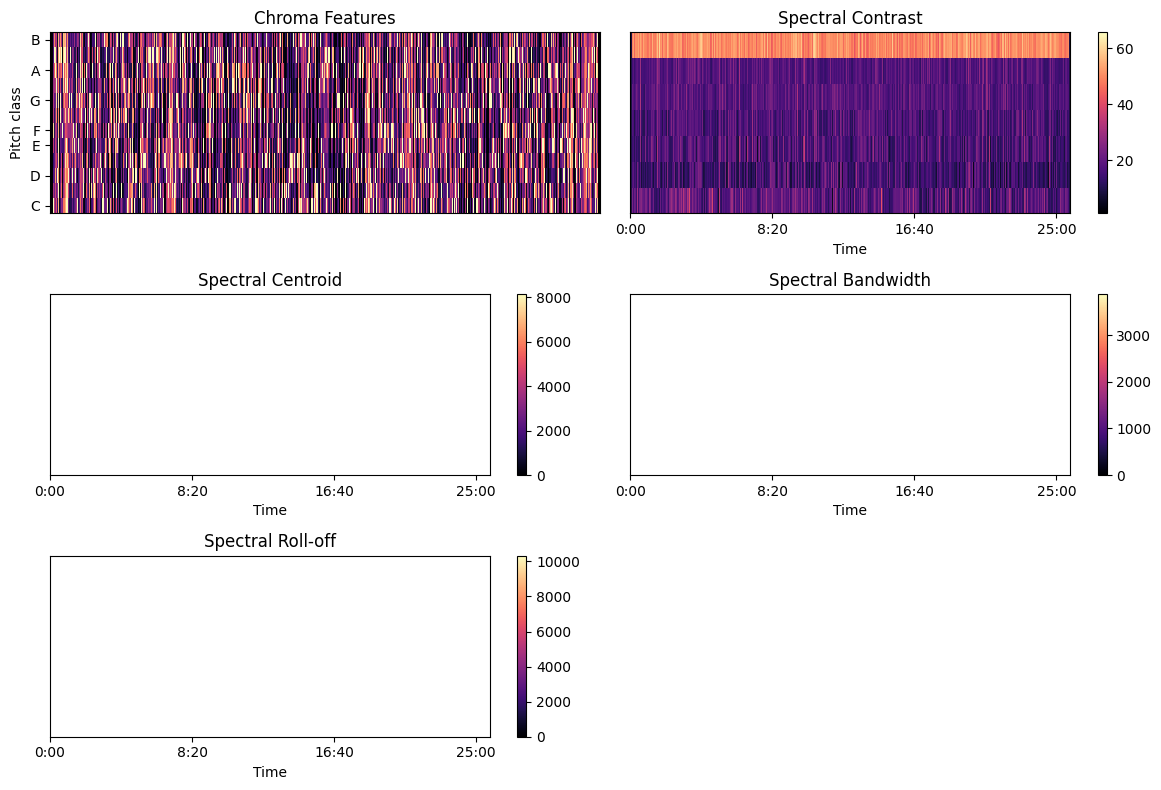

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = "../data/audio/Muppets-02-04-04.wav"
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis="chroma")
plt.title("Chroma Features")

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis="time")
plt.colorbar()
plt.title("Spectral Contrast")

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis="time")
plt.colorbar()
plt.title("Spectral Centroid")
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis="time")
plt.colorbar()
plt.title("Spectral Bandwidth")
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis="time")
plt.colorbar()
plt.title("Spectral Roll-off")
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()

(12, 66299)
(7, 66299)
(1, 66299)
(1, 66299)
(1, 66299)
Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Bandwidth: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Roll-off: [[0. 0. 0. ... 0. 0. 0.]]


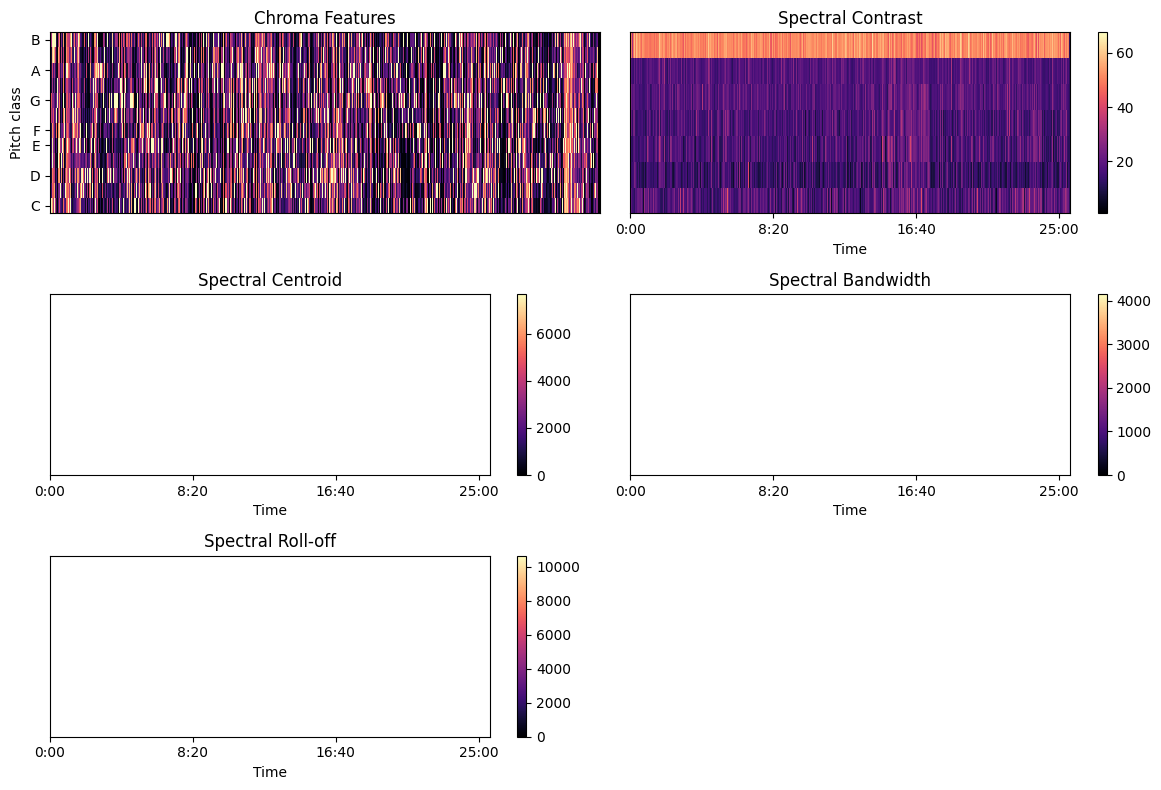

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = "../data/audio/Muppets-03-04-03.wav"
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis="chroma")
plt.title("Chroma Features")

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis="time")
plt.colorbar()
plt.title("Spectral Contrast")

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis="time")
plt.colorbar()
plt.title("Spectral Centroid")
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis="time")
plt.colorbar()
plt.title("Spectral Bandwidth")
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis="time")
plt.colorbar()
plt.title("Spectral Roll-off")
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()

In our SM1 audio notebook we have already used the following timbre features  
loudness rms  
zcr  
mfccs

This leaves us free to use the following timbre features for SM2:  
spectral flatness / perceived sharpness  
tonnetz  
mel centroid

Additionally, we try compute the fourier tempogram and STFT

For this audio approach, we do not want to operate on the audio files in their basic-from but employ STFT and extract timbre features on its basis. STFT provides a time-frequency representation of an audio signal, breaking it down into short time segments and revealing the frequency content within each segment. Timbre is closely related to spectral characteristics of sound, including the distribution of energy across different frequency bands. By analyzing the STFT, information about the frequency content at different points in time allows for detailed examiniation of spectral features. This aids distinguishing speech and singing patterns.


The following code cells contain some of our experiments on said audio features.


C:\Users\alina\AppData\Local\Temp\ipykernel_9752\3462702618.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


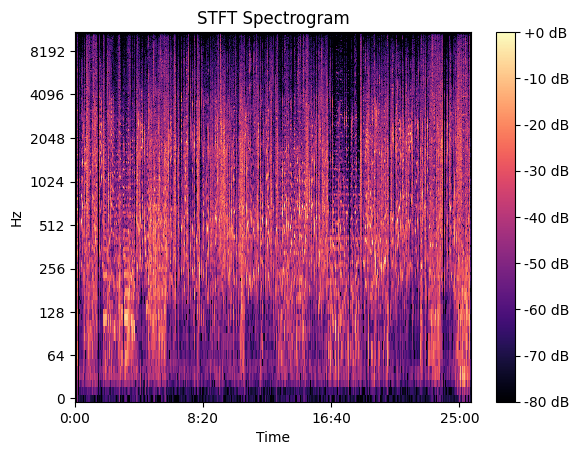

Zero Crossings: [[0.         0.         0.         ... 0.03613281 0.02832031 0.02099609]]
RMS Energy: [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.6840710e-05 1.4777792e-05
 1.2237879e-05]
Harmonic-to-Noise Ratio (HNR): [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.7491660e-05
 -1.5464770e-05 -1.1675758e-05]
Spectral Flatness: [[1.0000007  1.0000007  1.0000007  ... 0.05722385 0.06692996 0.09460584]]
Tonnetz: [[ 0.          0.          0.         ... -0.01516161  0.01703167
   0.01122424]
 [ 0.          0.          0.         ... -0.05483576 -0.05206411
  -0.02138115]
 [ 0.          0.          0.         ... -0.04859439 -0.04497281
  -0.03998579]
 [ 0.          0.          0.         ... -0.03672028 -0.03056692
  -0.00499801]
 [ 0.          0.          0.         ...  0.01351141  0.00037324
  -0.00739452]
 [ 0.          0.          0.         ... -0.00776486 -0.00810733
  -0.00215161]]
Mel-frequency Spectral Centroid: [[   0.            0.            0.         ... 4689.9317

In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file_path = "../data/audio/Muppets-02-01-01.wav"
y, sr = librosa.load(audio_file_path)

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Display the STFT spectrogram
librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max), y_axis="log", x_axis="time"
)
plt.title("STFT Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()
# Feature extraction
# zero_crossings = librosa.feature.zero_crossing_rate(y)
# rms = librosa.feature.rms(y=y)[0]  # Compute RMS energy
# hnr = librosa.effects.harmonic(y)
spectral_flatness = librosa.feature.spectral_flatness(y=y)
# Check if pitches and magnitudes are not empty before accessing the maximum value
hop_length = 512  # You can adjust this value based on your needs
n_fft = 2048  # You can adjust this value based on your needs
center = True  # You can set it to False if needed

tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
mel_centroid = librosa.feature.spectral_centroid(
    y=y, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center
)
sharpness = -librosa.feature.delta(spectral_flatness)

# Display or use the extracted features

# print("Harmonic-to-Noise Ratio (HNR):", hnr)
print("Spectral Flatness:", spectral_flatness)
print("Tonnetz:", tonnetz)
print("Mel-frequency Spectral Centroid:", mel_centroid)
print("Perceptual Sharpness:", sharpness)

C:\Users\alina\AppData\Local\Temp\ipykernel_9752\791250290.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


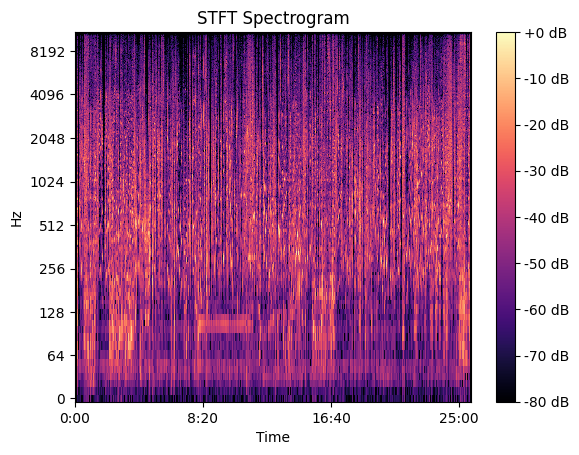

Harmonic-to-Noise Ratio (HNR): [0. 0. 0. ... 0. 0. 0.]
Tonnetz: [[ 0.          0.          0.         ...  0.0448432   0.00675244
   0.01239564]
 [ 0.          0.          0.         ...  0.1414606   0.08569031
   0.02552758]
 [ 0.          0.          0.         ...  0.04957253 -0.00952875
  -0.0147702 ]
 [ 0.          0.          0.         ... -0.02695864  0.01168429
   0.00547853]
 [ 0.          0.          0.         ...  0.08416764  0.01424239
  -0.01793548]
 [ 0.          0.          0.         ... -0.01636204  0.01703281
   0.04656267]]
Mel-frequency Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Perceptual Sharpness: [[-3.7717355e-17 -3.7717355e-17 -3.7717355e-17 ... -3.7717355e-17
  -3.7717355e-17 -3.7717355e-17]]
Spectral Flatness:  [[1.0000007 1.0000007 1.0000007 ... 1.0000007 1.0000007 1.0000007]]


In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file_path = "../data/audio/Muppets-02-04-04.wav"
y, sr = librosa.load(audio_file_path)

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Display the STFT spectrogram
librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max), y_axis="log", x_axis="time"
)
plt.title("STFT Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

# Feature extraction

# Calculate harmonic component from the STFT
y_harmonic, y_percussive = librosa.effects.hpss(y)
hnr = librosa.effects.harmonic(y_harmonic)

# Calculate tonnetz based on the harmonic component from the STFT
tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)

# Check if pitches and magnitudes are not empty before accessing the maximum value
hop_length = 512  # You can adjust this value based on your needs
n_fft = 2048  # You can adjust this value based on your needs
center = True  # You can set it to False if needed

# Calculate mel-frequency spectral centroid
mel_centroid = librosa.feature.spectral_centroid(
    S=np.abs(D) ** 2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center
)

# Calculate sharpness
spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D) ** 2)
sharpness = -librosa.feature.delta(spectral_flatness)

# Display or use the extracted features

print("Harmonic-to-Noise Ratio (HNR):", hnr)
print("Tonnetz:", tonnetz)
print("Mel-frequency Spectral Centroid:", mel_centroid)
print("Perceptual Sharpness:", sharpness)
print("Spectral Flatness: ", spectral_flatness)

Audio Feature Extraction Experiments


In [7]:
# padding of last 8s silence
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1

    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )

In [17]:
for audio in dataset.audios:
    y = audio["audio"]
    # Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length = int(
        audio["sr"] / FRAMES_PER_SECOND
    )  # You can adjust this value based on your needs
    n_fft = 2048  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    win_length = int(audio["sr"] / FRAMES_PER_SECOND)
    sr = FRAMES_PER_SECOND
    D = librosa.stft(y, hop_length=hop_length, win_length=win_length)

    # Calculate harmonic component from the STFT
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    # HNR
    hnr = librosa.effects.harmonic(y_harmonic)

    # Tonnetz
    # Calculate tonnetz based on the harmonic component from the STFT
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, hop_length=hop_length)
    # Check the data type of y
    if D.dtype != np.float32 and D.dtype != np.float64:
        # If not floating-point, convert to float32
        D = D.astype(np.float32)
    tonnetz = librosa.feature.tonnetz(
        y=y, sr=FRAMES_PER_SECOND, chroma=None, hop_length=hop_length
    )
    # Mel centroid
    mel_centroid = librosa.feature.spectral_centroid(
        S=np.abs(D) ** 2,
        sr=sr,
        hop_length=hop_length,
        n_fft=n_fft,
        center=center,
        win_length=win_length,
    )
    # spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(
        S=np.abs(D) ** 2, win_length=win_length, hop_length=hop_length
    )

    # perceptual sharpness
    sharpness = -librosa.feature.delta(spectral_flatness)
    audio["tonnetz_0"] = tonnetz[0]
    audio["tonnetz_1"] = tonnetz[1]
    audio["tonnetz_2"] = tonnetz[2]
    audio["tonnetz_3"] = tonnetz[3]
    audio["tonnetz_4"] = tonnetz[4]
    audio["tonnetz_5"] = tonnetz[5]
    audio["mel_centroid"] = mel_centroid
    audio["sharpness"] = sharpness

C:\Users\alina\AppData\Local\Temp\ipykernel_19616\602545356.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  D = D.astype(np.float32)


Unfortunately, we were not able to merge all of the computed features into our dataset. This was due to their shape - it did not match our number of frames and hence could not be assigned to them. There was a lot of experimentation to make them suitable like parameter tuning, but we could not make it work.
hnr: had a shape of > 6M, we were unable to assign it meaningfully to the frames
chromagram & tonnetz: we kept facing this error message, but could not find a way to solve the problem:
ParameterError Traceback (most recent call last)
Cell In[12], line 36
27 center = True # You can set it to False if needed
28 #HNR
29 #hnr = librosa.effects.harmonic(y_harmonic) #way too many features, cannot use
30
(...)
34 # Calculate chromagram using chroma_cqt
35 # Calculate chromagram using chroma_cqt with reduced fmin
---> 36 chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=FRAMES_PER_SECOND, fmin=librosa.note_to_hz('C1'))
38 # Calculate tonnetz based on the computed chromagram
39 tonnetz = librosa.feature.tonnetz(chroma=chromagram)

File c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\librosa\feature\spectral.py:1386, in chroma_cqt(y, sr, C, hop_length, fmin, norm, threshold, tuning, n_chroma, n_octaves, window, bins_per_octave, cqt_mode)
1381 if y is None:
1382 raise ParameterError(
1383 "At least one of C or y must be provided to compute chroma"
1384 )
1385 C = np.abs(
-> 1386 cqt_func[cqt_mode](
1387 y,
1388 sr=sr,
1389 hop_length=hop_length,
1390 fmin=fmin,
...
976 category=FutureWarning,
977 stacklevel=2,
978 )

ParameterError: Wavelet basis with max frequency=4106.18221930793 would exceed the Nyquist frequency=12.5. Try reducing the number of frequency bins.
If we tried to not compute the chromagram before (as it is not neccessary), we received an error that the win_length must be a positive integer...

The features we could merge into our dataset are:
mel_centroid
sharpness


## Dataset preparation for classification


In [19]:
# merging into dataset
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                    "sharpness": np.ravel(audio["sharpness"]),
                    "mel_centroid": np.ravel(audio["mel_centroid"]),
                }
            ),
        ],
        ignore_index=True,
    )
    # add annotations
    audio_features = audio_features.merge(
        dataset.annotations[
            ["Video", "Frame_number", "Audio_Pigs", "Audio_MissPiggy", "Audio_Cook"]
        ],
        how="left",
        left_on=["video_idx", "frame_idx"],
        right_on=["Video", "Frame_number"],
    )
audio_features = audio_features.drop(columns=["Frame_number", "Video"])

Sanity Check


In [21]:
assert dataset.annotations.shape[0] == audio_features.shape[0]
assert dataset.annotations["Audio_Cook"].sum() == audio_features["Audio_Cook"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Audio_Cook"].values, audio_features["Audio_Cook"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_Pigs"].values,
    audio_features["Audio_Pigs"].values,
)  #
np.testing.assert_array_equal(
    dataset.annotations["Audio_MissPiggy"].values,
    audio_features["Audio_MissPiggy"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    audio_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    audio_features["frame_idx"].values,
)

Sampling features for overview


In [23]:
audio_features.sample(10)
audio_features.drop(
    columns=[
        "Video_x",
        "Frame_number_x",
        "Audio_Pigs_x",
        "Audio_MissPiggy_x",
        "Audio_Cook_x",
        "Video_y",
        "Frame_number_y",
        "Audio_Pigs_y",
        "Audio_MissPiggy_y",
        "Audio_Cook_y",
    ]
)

,video_idx,frame_idx,sharpness,mel_centroid,Audio_Pigs,Audio_MissPiggy,Audio_Cook
0,0,0,-3.771735e-17,0.0,0,0,0
1,0,1,-3.771735e-17,0.0,0,0,0
2,0,2,-3.771735e-17,0.0,0,0,0
3,0,3,-3.771735e-17,0.0,0,0,0
4,0,4,3.469449e-18,0.0,0,0,0
...,...,...,...,...,...,...,...
115880,2,38493,3.469449e-18,0.0,0,0,0
115881,2,38494,-3.771735e-17,0.0,0,0,0
115882,2,38495,-3.771735e-17,0.0,0,0,0
115883,2,38496,-3.771735e-17,0.0,0,0,0


We extract the X and y matrices for the model:


In [30]:
# X,y split
X = audio_features.drop(
    columns=["Audio_MissPiggy", "Audio_Pigs", "Audio_Cook", "video_idx", "frame_idx"]
)
X.sample()
y = audio_features[["Audio_MissPiggy", "Audio_Pigs", "Audio_Cook"]]

And then split into train and test sets by a 80/20 ratio. However, we do not use a shuffled random split like one would often use in tabular-data machine learning: this would lead to test-set contamination, as neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets.
However, to observe the difference in results, we implemented both the random and non-random approaches and tried out both.

Due to this reasoning, we decide to use the first 80% of the ordered frames as training data and the last 20% as testing data.


In [25]:
RANDOM_SPLIT = True

In [39]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [42]:
# X_train.drop(columns=["Video_x","Frame_number_x","Audio_Pigs_x","Audio_MissPiggy_x","Audio_Cook_x","Video_y","Frame_number_y","Audio_Pigs_y","Audio_MissPiggy_y","Audio_Cook_y"],inplace=True)
# X_train.sample()
# X_test.drop(columns=["Video_x","Frame_number_x","Audio_Pigs_x","Audio_MissPiggy_x","Audio_Cook_x","Video_y","Frame_number_y","Audio_Pigs_y","Audio_MissPiggy_y","Audio_Cook_y"],inplace=True)
# sampling our X
X_test.sample()

,sharpness,mel_centroid
52014,8.124479e-08,0.6036


Training the audio-based model

For this task, we decided to use the ridge classifier as a rather complex classifier based on ridge regression.

We train one model for each of the classification tasks, so that we can avoid multiclass classification. In doubt of whether the Audio_MissPiggy groundtruth labels are a subset of the Audio_Pigs groundtruth labels or not, we handled miss piggy as a seperate character, resulting in 3 models.  
Pigs  
Swedish Chef  
Miss Piggy


In [43]:
# pigs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

max_iter = 100
rc_pigs = RidgeClassifier()
rc_pigs.fit(X_train, y_train["Audio_Pigs"])

if rc_pigs.n_iter_ == max_iter:
    print(
        "Solver has reached the maximum number of iterations. Consider increasing max_iter."
    )
else:
    print("Solver has converged within the specified max_iter.")

y_pred_pigs = rc_pigs.predict(X_test)

Solver has converged within the specified max_iter.


As we can see in the following computed metrics this did not work at all for any of the characters to predict.


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_Pigs Predominant Color only: 
Accuracy: 0.9453337360314105
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[21910     0]
 [ 1267     0]]


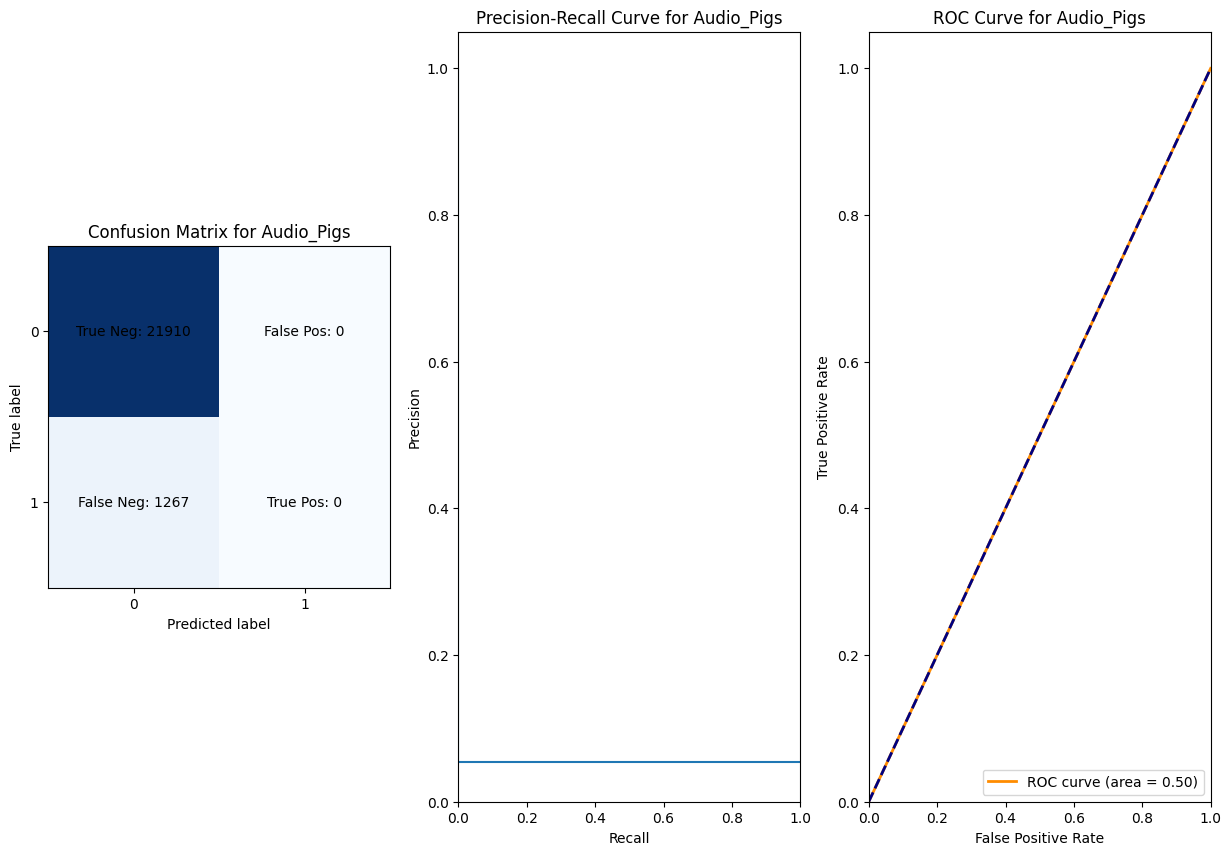

In [44]:
# evaluation metrics for pigs


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"], y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs with Sharpness & mel centroid: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"],
    y_pred_pigs,
    "Precision-Recall Curve for Audio_Pigs",
    ax=axs[1],
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [45]:
# miss piggy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

max_iter = 100
rc_mp = RidgeClassifier()
rc_mp.fit(X_train, y_train["Audio_MissPiggy"])

if rc_mp.n_iter_ == max_iter:
    print(
        "Solver has reached the maximum number of iterations. Consider increasing max_iter."
    )
else:
    print("Solver has converged within the specified max_iter.")

y_pred_mp = rc_mp.predict(X_test)

Solver has converged within the specified max_iter.


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_MissPiggy Predominant Color only: 
Accuracy: 0.9630668334987272
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[22321     0]
 [  856     0]]


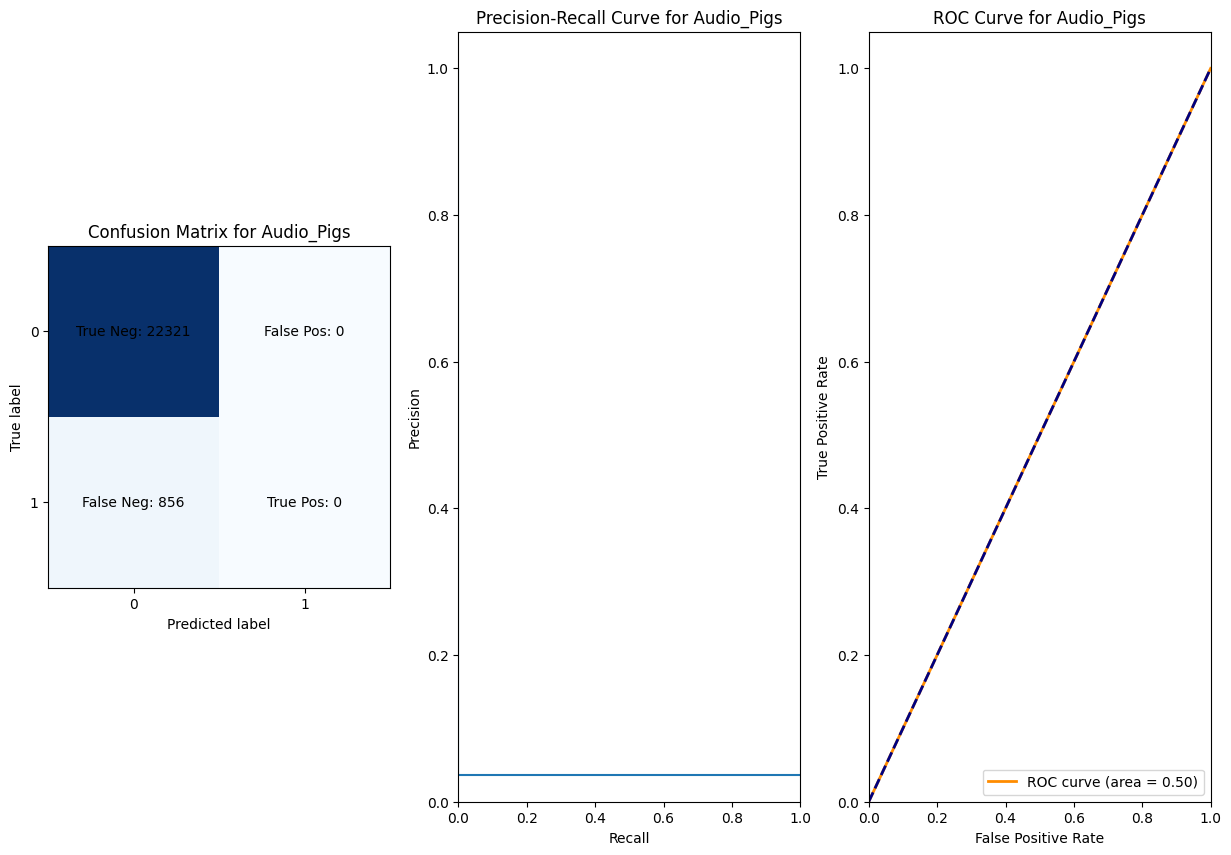

In [46]:
# evaluation metrics for miss piggy


accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"], y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy Sharpness & mel centroid: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"],
    y_pred_mp,
    "Precision-Recall Curve for Audio_Pigs",
    ax=axs[1],
)
plot_roc_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Audio_Pigs", ax=axs[2]
)

In [47]:
# cook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

max_iter = 100
rc_cook = RidgeClassifier()
rc_cook.fit(X_train, y_train["Audio_Cook"])

if rc_cook.n_iter_ == max_iter:
    print(
        "Solver has reached the maximum number of iterations. Consider increasing max_iter."
    )
else:
    print("Solver has converged within the specified max_iter.")

y_pred_cook = rc_cook.predict(X_test)

Solver has converged within the specified max_iter.


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_Cook Predominant Color only: 
Accuracy: 0.9861500625620226
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[22856     0]
 [  321     0]]


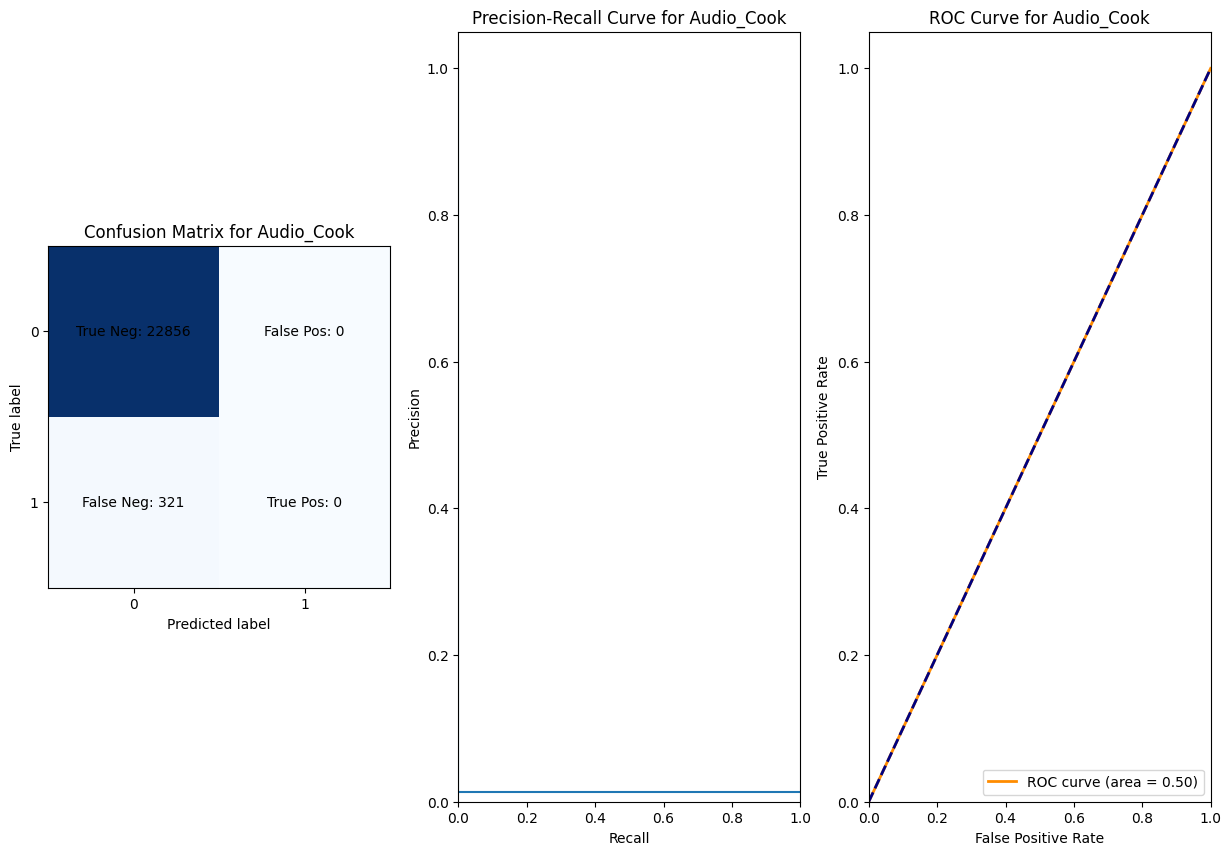

In [48]:
# evaluation metrics for cook

accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"], y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook Sharpness & mel centroid: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"],
    y_pred_cook,
    "Precision-Recall Curve for Audio_Cook",
    ax=axs[1],
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

As we could not make any useful predictions based on the features sharpness and mel centroid, we tried to compute other features as well. The tonnetz and chromagram unfortunately had to be skipped again - due to the same persisting errors. Now we tried to compute the following features:  
dynamic tempo (dtempo)  
poly_features  
auto-correlated_ft_tempogram  
onset_strength  
onset_envelope  
skewness  
kurtosis  
cqt: had to be skipped due this error: Always throwing a parameter error like this: ParameterError: Wavelet basis with max frequency=3951.066410048993 would exceed the Nyquist frequency=12.5. Try reducing the number of frequency bins.  
We suppose it just does not work on our audio size with the given sample rate.


In [19]:
import scipy.stats

for audio in dataset.audios:
    y = audio["audio"]
    # Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length = int(
        audio["sr"] / FRAMES_PER_SECOND
    )  # You can adjust this value based on your needs
    n_fft = 2048  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    win_length = int(audio["sr"] / FRAMES_PER_SECOND)
    sr = FRAMES_PER_SECOND
    D = librosa.stft(y, hop_length=hop_length, win_length=win_length)

    # Calculate harmonic component from the STFT
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    # HNR
    hnr = librosa.effects.harmonic(y_harmonic)

    # Tonnetz
    # Calculate tonnetz based on the harmonic component from the STFT
    # chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, hop_length=hop_length)
    # Check the data type of y
    # if D.dtype != np.float32 and D.dtype != np.float64:
    # # If not floating-point, convert to float32
    #     D = D.astype(np.float32)
    # tonnetz = librosa.feature.tonnetz(y=y, sr = FRAMES_PER_SECOND,chroma=None)
    # Mel centroid
    mel_centroid = librosa.feature.spectral_centroid(
        S=np.abs(D) ** 2,
        sr=sr,
        hop_length=hop_length,
        n_fft=n_fft,
        center=center,
        win_length=win_length,
    )
    # spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(
        S=np.abs(D) ** 2, win_length=win_length, hop_length=hop_length
    )
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(
        y=y,
        sr=sr,
        onset_envelope=onset_env,
        hop_length=hop_length,
        win_length=win_length,
    )
    dtempo = librosa.feature.tempo(
        y=y, tg=tempogram, sr=sr, hop_length=hop_length, aggregate=None
    )
    poly_features = librosa.feature.poly_features(
        y=y, sr=sr, hop_length=hop_length, win_length=win_length
    )
    ft_tempogram = librosa.feature.fourier_tempogram(
        y=y, sr=sr, hop_length=hop_length, win_length=win_length
    )
    ac_tempogram = librosa.feature.tempogram(
        onset_envelope=onset_env,
        sr=sr,
        hop_length=hop_length,
        win_length=win_length,
        norm=None,
    )

    onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    magnitude, phase = librosa.magphase(D)
    skewness = scipy.stats.skew(magnitude, axis=1)
    kurtosis = scipy.stats.kurtosis(magnitude, axis=1)

    audio["dtempo"] = dtempo
    audio["poly_features"] = poly_features
    audio["ac_ft_tempogram"] = ac_tempogram
    audio["onset_strength"] = onset_strength
    audio["onset_env"] = onset_env
    audio["skewness"] = skewness
    audio["kurtosis"] = kurtosis
    # audio["cqt"]=cqt

As we can see, the most of the feature shapes do not match our amount of dataframes and hence cannot be used. We could not find any relation nor reasoning for the data to look this for our given sr, hop_length, win_length. After several tries of reshaping, we had to skip all of these features except for poly_features.


In [20]:
print(dataset.audios[0]["dtempo"].shape)
print(dataset.audios[0]["poly_features"].shape)
print(dataset.audios[0]["ac_ft_tempogram"].shape)
print(dataset.audios[0]["onset_strength"].shape)
print(dataset.audios[1]["onset_env"].shape)
print(dataset.audios[1]["onset_env"])
print(dataset.audios[0]["skewness"].shape)
print(dataset.audios[0]["kurtosis"].shape)

(133265,)
(2, 38681)
(1764, 133265)
(133265,)
(133351,)
[0. 0. 0. ... 0. 0. 0.]
(1025,)
(1025,)


Hence, we next tried to compute the beats as bmp per frame, which did not work out either - again error concerning the win-length.

```````ParameterError Traceback (most recent call last)
Cell In[8], line 15
13 onset_env = librosa.onset.onset_strength(y=y, sr=sr,win_length=win_length, hop_length=hop_length)
14 print(win_length)
---> 15 tempo, beats = librosa.beat.beat_track(y=y,onset_envelope=onset_env,units='frames',hop_length=hop_length,
16 sr=sr)
17 # onset_env = librosa.onset.onset_strength(y=y, sr=sr)
18 # tempogram = librosa.feature.tempogram(y=y, sr=sr, onset_envelope=onset_env, hop_length=hop_length, win_length=win_length)
19 #dtempo = librosa.feature.tempo(y=y, tp = tempogram,onset_envelope=onset_env,sr=sr, aggregate=None)
(...)
29 #skewness = scipy.stats.skew(magnitude,axis=1)
30 #kurtosis =scipy.stats.kurtosis(magnitude,axis=1)
31 audio["beats"]=beats

File c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\librosa\beat.py:176, in beat_track(y, sr, onset_envelope, hop_length, start_bpm, tightness, trim, bpm, prior, units)
174 # Estimate BPM if one was not provided
175 if bpm is None:
--> 176 bpm = \_tempo(
177 onset_envelope=onset_envelope,
178 sr=sr,
179 hop_length=hop_length,
180 start_bpm=start_bpm,
181 prior=prior,
182 )[0]
...
--> 143 raise ParameterError("win_length must be a positive integer")
145 ac_window = get_window(window, win_length, fftbins=True)
147 if onset_envelope is None:

ParameterError: win_length must be a positive integer``````
```````


In [8]:
for audio in dataset.audios:
    y = audio["audio"]
    # Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length = int(
        audio["sr"] / FRAMES_PER_SECOND
    )  # You can adjust this value based on your needs
    n_fft = 2048  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    win_length = int(audio["sr"] / FRAMES_PER_SECOND)
    sr = FRAMES_PER_SECOND
    D = librosa.stft(y, hop_length=hop_length, win_length=win_length)

    # Calculate harmonic component from the STFT
    # y_harmonic, y_percussive = librosa.effects.hpss(y)
    onset_env = librosa.onset.onset_strength(
        y=y, sr=sr, win_length=win_length, hop_length=hop_length
    )
    print(win_length)
    tempo, beats = librosa.beat.beat_track(
        y=y, onset_envelope=onset_env, units="frames", hop_length=hop_length, sr=sr
    )
    # onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    # tempogram = librosa.feature.tempogram(y=y, sr=sr, onset_envelope=onset_env, hop_length=hop_length, win_length=win_length)
    # dtempo = librosa.feature.tempo(y=y, tp = tempogram,onset_envelope=onset_env,sr=sr, aggregate=None)
    # tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,
    # sr=sr)
    # poly_features = librosa.feature.poly_features(y=y,sr=sr, hop_length=hop_length, win_length=win_length)
    # ft_tempogram = librosa.feature.fourier_tempogram(y=y,sr=sr, hop_length=hop_length,win_length=win_length)
    # ac_tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr,hop_length=hop_length, win_length=win_length, norm=None)

    # onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    # magnitude,phase = librosa.magphase(D)
    # skewness  = scipy.stats.skew(magnitude,axis=1)
    # kurtosis =scipy.stats.kurtosis(magnitude,axis=1)
    audio["beats"] = beats
    print(beats.shape)
# audio["dtempo"]=dtempo
# audio["poly_features"]=poly_features
# audio["ac_ft_tempogram"]=ac_tempogram
# audio["onset_strength"]=onset_strength
# audio["onset_env"]=onset_env
# audio["skewness"]=skewness
#  audio["kurtosis"]=kurtosis
# audio["cqt"]=cqt

1764


ParameterError: win_length must be a positive integer

So we tried training the models based on the poly features


In [14]:
# merging into dataset
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                    # "dtempo":audio["dtempo"],
                    "poly_features_1": audio["poly_features"][0],
                    "poly_features_2": audio["poly_features"][1],
                }
            ),
        ],
        ignore_index=True,
    )
    # add annotations
    audio_features = audio_features.merge(
        dataset.annotations[
            ["Video", "Frame_number", "Audio_Pigs", "Audio_MissPiggy", "Audio_Cook"]
        ],
        how="left",
        left_on=["video_idx", "frame_idx"],
        right_on=["Video", "Frame_number"],
    )
audio_features = audio_features.drop(columns=["Frame_number", "Video"])

In [15]:
audio_features.sample(10)

,video_idx,frame_idx,poly_features_1,poly_features_2,Video_x,Frame_number_x,Audio_Pigs_x,Audio_MissPiggy_x,Audio_Cook_x,Video_y,Frame_number_y,Audio_Pigs_y,Audio_MissPiggy_y,Audio_Cook_y,Audio_Pigs,Audio_MissPiggy,Audio_Cook
52173,1,13492,-0.017835,0.160929,NaN,NaN,NaN,NaN,NaN,1.0,13492.0,0.0,0.0,0.0,0,0,0
1878,0,1878,-0.019656,0.177917,0.0,1878.0,0.0,0.0,0.0,0.0,1878.0,0.0,0.0,0.0,0,0,0
110127,2,32740,-0.015174,0.132497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
36003,0,36003,-0.072232,0.636257,0.0,36003.0,0.0,0.0,0.0,0.0,36003.0,0.0,0.0,0.0,0,0,0
58854,1,20173,-0.015808,0.136227,NaN,NaN,NaN,NaN,NaN,1.0,20173.0,1.0,1.0,0.0,1,1,0
78410,2,1023,-0.148354,1.284629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
38881,1,200,-0.103735,0.934221,NaN,NaN,NaN,NaN,NaN,1.0,200.0,0.0,0.0,0.0,0,0,0
45086,1,6405,-0.046736,0.423450,NaN,NaN,NaN,NaN,NaN,1.0,6405.0,0.0,0.0,0.0,0,0,0
111122,2,33735,-0.048564,0.425281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
90069,2,12682,-0.066449,0.588277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [17]:
# X,y split
# X = audio_features.drop(
#     columns=["Audio_MissPiggy","Audio_Pigs","Audio_Cook","video_idx","frame_idx"]
# )
X.sample()
y = audio_features[["Audio_MissPiggy", "Audio_Pigs", "Audio_Cook"]]
X = audio_features[["poly_features_1", "poly_features_2"]]

In [18]:
RANDOM_SPLIT = True
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [19]:
# pigs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

max_iter = 100
rc_pigs = RidgeClassifier()
rc_pigs.fit(X_train, y_train["Audio_Pigs"])

if rc_pigs.n_iter_ == max_iter:
    print(
        "Solver has reached the maximum number of iterations. Consider increasing max_iter."
    )
else:
    print("Solver has converged within the specified max_iter.")

y_pred_pigs = rc_pigs.predict(X_test)

Solver has converged within the specified max_iter.


As again, we instantly received results that the ridge classifier model always predicts no character presence, we thought it might have to do something with the chosen classifier - especially as the training was much faster than we were used to from the other notebooks. So, we tried svm classification as well and received the same results.


In [21]:
from sklearn.svm import SVC

svm_pigs = SVC()

svm_pigs.fit(X_train, y_train["Audio_Pigs"])

y_pred_pigs = svm_pigs.predict(X_test)

c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_Pigs Predominant Color only: 
Accuracy: 0.9453337360314105
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[21910     0]
 [ 1267     0]]


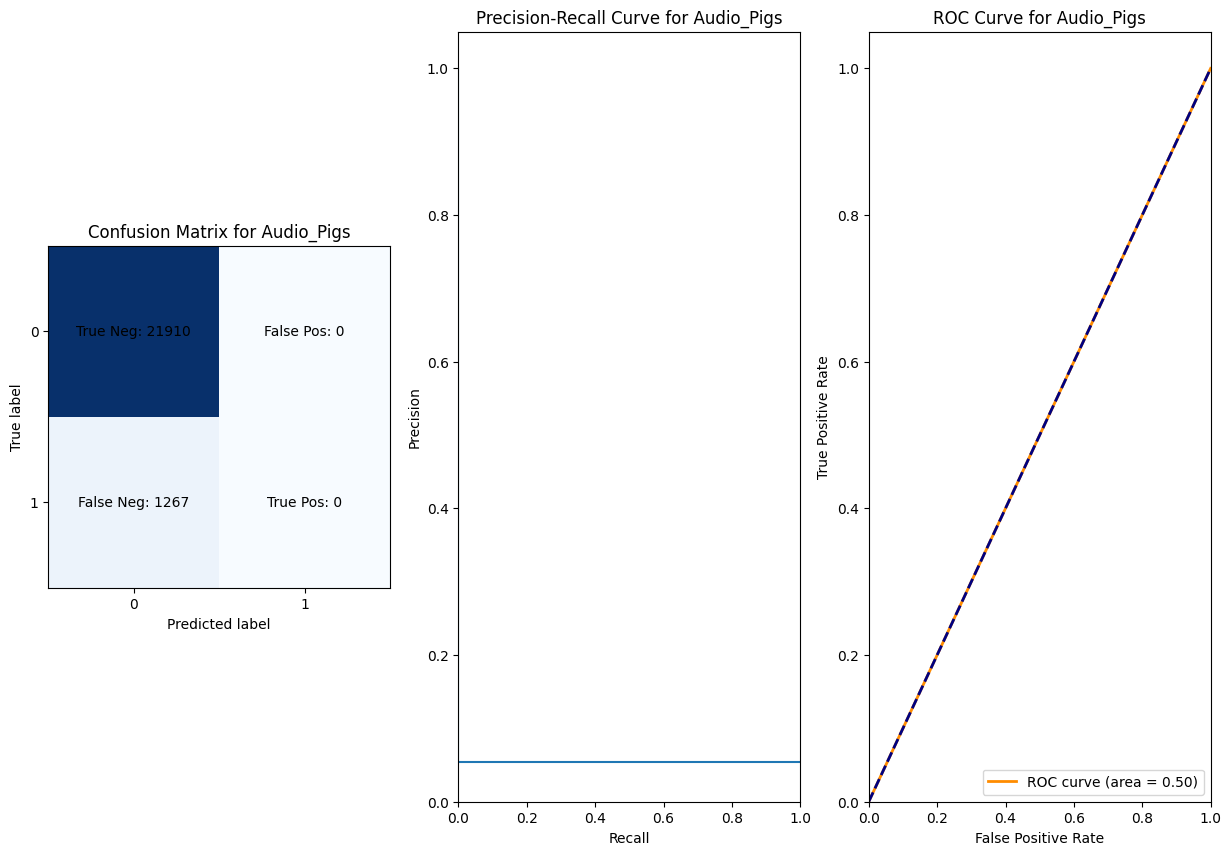

In [22]:
# evaluation metrics for pigs


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"], y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs with svm: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"],
    y_pred_pigs,
    "Precision-Recall Curve for Audio_Pigs",
    ax=axs[1],
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [12]:
from sklearn.preprocessing import normalize

sr = 25
# audio feature extractison
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1
    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )
    y = audio["audio"]
    # applying STFT
    D = librosa.stft(y)

    # Calculate harmonic component from the STFT
    # y_harmonic, y_percussive = librosa.effects.hpss(y)
    y_harmonic, sr = load_audio_frame(idx)
    chromagram = librosa.feature.chroma_cqt(
        y=y_harmonic, sr=sr, fmin=librosa.note_to_hz("C1")
    )
    tonnetz = librosa.feature.tonnetz(chroma=chromagram)

    # Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length = int(audio["sr"] / 25)  # You can adjust this value based on your needs
    n_fft = int(audio["sr"] / 25)  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    # HNR
    # hnr = librosa.effects.harmonic(y_harmonic) #way too many features, cannot use

    # Tonnetz
    # Calculate tonnetz based on the harmonic component from the STFT
    # tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    # Calculate chromagram using chroma_cqt
    # Calculate chromagram using chroma_cqt with reduced fmin
    chromagram = librosa.feature.chroma_cqt(
        y=y_harmonic, sr=FRAMES_PER_SECOND, fmin=librosa.note_to_hz("C1")
    )

    # Calculate tonnetz based on the computed chromagram
    tonnetz = librosa.feature.tonnetz(chroma=chromagram)

    # Mel centroid
    mel_centroid = librosa.feature.spectral_centroid(
        S=np.abs(D) ** 2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center
    )
    # spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D) ** 2)

    # perceptual sharpness
    sharpness = -librosa.feature.delta(spectral_flatness)

    # ft tempgram
    # oenv = librosa.onset_strength(y=y,sr=sr, hop_length = hop_length )
    # ft_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,
    #                                              hop_length=hop_length)
    # normalize
    # hnr =normalize(np.reshape(hnr, (1, -1)))
    tonnetz = normalize(tonnetz)
    mel_centroid = normalize(mel_centroid)
    sharpness = normalize(sharpness)
    spectral_flatness = normalize(spectral_flatness)

    # set features
    # audio["hnr"] = hnr
    audio["tonnetz"] = tonnetz
    audio["mel_centroid"] = mel_centroid
    audio["sharpness"] = sharpness
    audio["spectral_flatness"] = spectral_flatness
    # audio["ft_tempogram"] = ft_tempogram

c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


ParameterError: Wavelet basis with max frequency=4106.18221930793 would exceed the Nyquist frequency=12.5. Try reducing the number of frequency bins.

In [17]:
print(dataset.audios[0]["tonnetz"].shape)
print(dataset.audios[0]["hnr"].shape)
print(dataset.audios[0]["mel_centroid"].shape)
print(dataset.audios[0]["sharpness"].shape)
print(dataset.audios[0]["spectral_flatness"].shape)

print(dataset.audios[1]["tonnetz"].shape)
print(dataset.audios[1]["hnr"].shape)
print(dataset.audios[1]["mel_centroid"].shape)
print(dataset.audios[1]["sharpness"].shape)
print(dataset.audios[1]["spectral_flatness"].shape)

print(dataset.audios[2]["tonnetz"].shape)
print(dataset.audios[2]["hnr"].shape)
print(dataset.audios[2]["mel_centroid"].shape)
print(dataset.audios[2]["sharpness"].shape)
print(dataset.audios[2]["spectral_flatness"].shape)

(6, 133265)
(1, 68231520)
(1, 133265)
(1, 133265)
(1, 133265)
(6, 133351)
(1, 68275620)
(1, 133351)
(1, 133351)
(1, 133351)
(6, 132635)
(1, 67908708)
(1, 132635)
(1, 132635)
(1, 132635)


Out of desperation for not being abel to predict any character presence, we decided to try it with features we also extracted in our SM1 audio notebook. Note that they not all were used for classification there.


For a clean procedure, we executed the dataset creation cell again before executing the following cells to work with a clean dataset.


In [245]:
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1

    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )

Extraction of features from SM1 and the new ones that worked (sharpness, poly features)


In [246]:
sr = FRAMES_PER_SECOND
hop_length = int(audio["sr"] / FRAMES_PER_SECOND)
win_length = int(audio["sr"] / FRAMES_PER_SECOND)


for audio in dataset.audios:
    # Spectral contrast measures the difference in amplitude between peaks and valleys in the spectrum, which can capture aspects of timbre
    audio["spectral_contrast"] = librosa.util.normalize(
        librosa.feature.spectral_contrast(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_bands=5,
        )
    )  # spectral contrast values across n_bands different frequency bands for each frame, +1 that is "overall"
    # Spectral roll-off provides insights into the shape of the spectral energy distribution, affecting the timbre
    audio["spectral_rolloff"] = librosa.util.normalize(
        librosa.feature.spectral_rolloff(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )
    # Chroma features represent the energy distribution across different pitch classes and can provide a view of the harmonic content that contributes to timbre.
    audio["chroma"] = librosa.util.normalize(
        librosa.feature.chroma_stft(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )
    )
    # MFCCs are one of the most popular features for capturing the timbre of a sound. They effectively represent the short-term power spectrum of a sound.
    audio["mfcc"] = librosa.util.normalize(
        librosa.feature.mfcc(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_mfcc=19,
        )
    )
    # Spectral centroid indicates the “center of mass” of the spectrum and can be used to describe the brightness of a sound, a key aspect of timbre.
    audio["spectral_centroid"] = librosa.util.normalize(
        librosa.feature.spectral_centroid(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )
    )[0]
    # poly features
    S = np.abs(
        librosa.stft(audio["audio"], hop_length=hop_length, win_length=win_length)
    )
    audio["poly_features"] = librosa.feature.poly_features(
        S=S, sr=audio["sr"], hop_length=hop_length, win_length=win_length
    )
    spectral_flatness = librosa.feature.spectral_flatness(
        S=S, win_length=win_length, hop_length=hop_length
    )

    # perceptual sharpness
    sharpness = -librosa.feature.delta(spectral_flatness)
    audio["sharpness"] = sharpness
    # Pitch
    pitches, magnitudes = librosa.piptrack(
        y=audio["audio"],
        sr=audio["sr"],
        hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
        win_length=int(audio["sr"] / FRAMES_PER_SECOND),
    )
    audio["pitch_mean"] = librosa.util.normalize(pitches.mean(axis=0))
    audio["magnitude_mean"] = librosa.util.normalize(magnitudes.mean(axis=0))
    audio["pitch_sd"] = librosa.util.normalize(pitches.std(axis=0))
    audio["magnitude_sd"] = librosa.util.normalize(magnitudes.std(axis=0))
    audio["pitch_min"] = librosa.util.normalize(pitches.min(axis=0))
    audio["magnitude_min"] = librosa.util.normalize(magnitudes.min(axis=0))
    audio["pitch_max"] = librosa.util.normalize(pitches.min(axis=0))
    audio["magnitude_max"] = librosa.util.normalize(magnitudes.min(axis=0))

In [253]:
print(dataset.audios[0]["sharpness"].shape)

(1, 38681)


In [248]:
# sanity check
for i in range(3):
    assert (
        dataset.audios[i]["spectral_rolloff"].shape[0]
        == dataset.annotations.loc[dataset.annotations.Video == i].Frame_number.max()
        + 1
    )

Merging features that fit SM2 context into the dataset and add annotations


In [254]:
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                    # "loudness_rms": audio["loudness_rms"],
                    #  "zcr": audio["zcr"],
                    "spectral_contrast_1": audio["spectral_contrast"][0],
                    "spectral_contrast_2": audio["spectral_contrast"][1],
                    "spectral_contrast_3": audio["spectral_contrast"][2],
                    "spectral_contrast_4": audio["spectral_contrast"][3],
                    "spectral_contrast_5": audio["spectral_contrast"][4],
                    "spectral_contrast_6": audio["spectral_contrast"][5],
                    "chroma1": audio["chroma"][0],
                    "chroma2": audio["chroma"][1],
                    "chroma3": audio["chroma"][2],
                    "chroma4": audio["chroma"][3],
                    "chroma5": audio["chroma"][4],
                    "chroma6": audio["chroma"][5],
                    "mfcc1": audio["mfcc"][0],
                    "mfcc2": audio["mfcc"][1],
                    "mfcc3": audio["mfcc"][2],
                    "mfcc4": audio["mfcc"][3],
                    "mfcc5": audio["mfcc"][4],
                    "mfcc6": audio["mfcc"][5],
                    "mfcc7": audio["mfcc"][6],
                    "mfcc8": audio["mfcc"][7],
                    "mfcc9": audio["mfcc"][8],
                    "mfcc10": audio["mfcc"][9],
                    "mfcc11": audio["mfcc"][10],
                    "mfcc12": audio["mfcc"][11],
                    "mfcc13": audio["mfcc"][12],
                    "mfcc14": audio["mfcc"][13],
                    "mfcc15": audio["mfcc"][14],
                    "mfcc16": audio["mfcc"][15],
                    "mfcc17": audio["mfcc"][16],
                    "mfcc18": audio["mfcc"][17],
                    "mfcc19": audio["mfcc"][18],
                    "spectral_rolloff": audio["spectral_rolloff"],
                    "spectral_centroid": audio["spectral_centroid"],
                    "poly_features_1": audio["poly_features"][0],
                    "poly_features_2": audio["poly_features"][1],
                    "sharpness": audio["sharpness"].ravel(),
                }
            ),
        ],
        ignore_index=True,
    )
# Add annotations
audio_features = audio_features.merge(
    dataset.annotations[
        ["Video", "Frame_number", "Audio_Pigs", "Audio_MissPiggy", "Audio_Cook"]
    ],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
audio_features = audio_features.drop(columns=["Frame_number", "Video"])

In [255]:
# sanity check
assert dataset.annotations.shape[0] == audio_features.shape[0]
assert dataset.annotations["Audio_Cook"].sum() == audio_features["Audio_Cook"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Audio_Cook"].values, audio_features["Audio_Cook"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_Pigs"].values,
    audio_features["Audio_Pigs"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_MissPiggy"].values,
    audio_features["Audio_MissPiggy"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    audio_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    audio_features["frame_idx"].values,
)

The following cell was re-used several times to create different X matrices that differ in their features for trying out different feature combinations for model training and prediction. In any case, we dropped the columns mfcc1, spectral contrast 6 and spectral centroid as they had the same value for any row and therefore would not aid model training.


In [320]:
# X = audio_features.drop(
#      columns=["Audio_Cook", "Audio_MissPiggy","Audio_Pigs", "video_idx", "frame_idx"]
#  )
y = audio_features[["Audio_Cook", "Audio_Pigs", "Audio_MissPiggy"]]
# X = audio_features.filter(like='mfcc').join(audio_features.filter(like='poly')).join(audio_features.filter(like="chroma")).join(audio_features.filter(like="spectral")).join(audio_features.filter(like="sharpness"))
# X=audio_features.filter(like='mfcc')
# X=audio_features.filter(like="mfcc")
X = audio_features.filter(like="mfcc").join(
    audio_features.filter(like="spectral_contrast")
)

if "mfcc1" in X.columns:
    X = X.drop("mfcc1", axis=1)
if "spectral_contrast_6" in X.columns:
    X = X.drop("spectral_contrast_6", axis=1)
if "spectral_centroid" in X.columns:
    X = X.drop("spectral_centroid", axis=1)

X.sample(10)

,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5
98782,0.264989,-0.184544,0.177311,-0.002724,-0.037358,-0.026165,0.038727,0.050007,-0.038008,-0.024253,...,-0.037581,-0.044926,-0.021367,-0.012918,-0.012825,0.245680,0.198891,0.287492,0.280020,0.325741
56364,0.475789,-0.093299,0.061802,-0.022581,0.046624,0.009504,-0.052322,-0.017021,-0.059135,-0.032616,...,-0.013219,0.009076,-0.007822,-0.027824,-0.016230,0.605577,0.304957,0.541289,0.445939,0.401706
72018,0.858556,-0.417277,0.075308,-0.130325,-0.001206,-0.003653,-0.026645,-0.001502,-0.037284,-0.000415,...,0.007451,-0.019320,-0.021676,-0.012459,-0.064120,0.345096,0.098092,0.241707,0.259007,0.354257
38480,0.819589,-0.374055,0.320342,-0.164333,0.172017,-0.082835,0.013184,-0.014627,-0.038239,0.005588,...,0.024257,0.026337,0.044802,-0.003846,-0.000726,0.379504,0.121954,0.260246,0.297785,0.300800
58518,0.327149,0.014623,0.052189,0.062774,0.039482,0.002708,-0.012485,-0.024103,-0.045288,-0.029058,...,-0.018193,-0.013132,-0.023968,-0.018648,-0.017382,0.299099,0.624978,0.472692,0.364681,0.546974
51720,0.389110,-0.212536,0.078072,0.088176,0.108883,-0.067160,-0.072840,0.033400,-0.024213,-0.030121,...,-0.018728,-0.053415,0.009922,-0.031259,-0.002555,0.507451,0.422195,0.342346,0.452078,0.318504
16018,0.578967,-0.232758,0.089373,-0.068611,-0.038098,-0.030178,-0.070829,0.002274,-0.082375,-0.071142,...,-0.016020,0.002511,-0.035452,-0.016720,-0.006873,0.581147,0.115965,0.288437,0.290560,0.242759
53101,0.168635,0.001102,0.005571,0.022768,0.006291,0.002190,0.006975,0.017654,0.028253,0.034255,...,-0.005244,-0.000956,0.006497,0.020140,0.017335,0.547747,0.253592,0.474908,0.493151,0.404338
104630,0.538148,-0.202746,-0.021602,-0.041458,-0.068924,-0.031156,-0.074883,-0.060347,-0.080602,-0.015479,...,-0.028875,-0.030266,-0.020916,0.023925,-0.000132,0.337060,0.166331,0.256690,0.256578,0.496178
93149,0.383851,-0.053157,0.042245,0.000581,-0.024392,-0.015599,-0.047642,-0.049130,-0.038525,-0.008991,...,-0.030666,0.026286,0.025543,-0.012630,-0.006550,0.556065,0.206707,0.332858,0.359325,0.376303


In [321]:
X.sample(10)

,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5
99155,0.166984,-0.151894,0.190948,-0.118857,0.049340,0.023312,0.009481,0.023044,0.009667,-0.023779,...,0.015134,-0.012387,-0.007845,-0.007058,-0.001927,0.301177,0.197604,0.172085,0.223726,0.286507
12941,0.476884,-0.035401,-0.034828,0.003748,0.032666,-0.038412,-0.070249,-0.009575,-0.059351,-0.070611,...,-0.011016,-0.045446,-0.024112,0.029845,0.008275,0.444923,0.599806,0.534666,0.660210,0.579541
97846,0.553753,-0.116897,0.008208,-0.079994,-0.060625,0.018382,-0.005154,-0.000474,-0.041541,-0.035367,...,-0.024415,-0.003934,-0.005634,-0.031497,-0.045584,0.664386,0.087331,0.275529,0.370224,0.449620
3309,0.504839,-0.105123,0.092009,-0.016432,0.067334,0.022838,-0.002162,0.024960,-0.008800,0.029795,...,0.003829,0.038503,0.008551,-0.031419,-0.051468,0.392249,0.364928,0.575529,0.472134,0.553575
54958,0.358693,-0.143121,-0.000138,-0.039993,0.095968,0.049589,-0.087805,0.027497,-0.000429,0.007768,...,-0.022244,-0.018148,0.026165,0.035124,0.033894,0.400805,0.399863,0.531234,0.501712,0.503713
54150,0.492237,-0.223074,0.010121,0.017556,0.111520,-0.159446,-0.112660,-0.012576,-0.066561,-0.000587,...,-0.010705,0.016769,0.047488,-0.029328,-0.041018,0.278569,0.187980,0.322570,0.376828,0.527296
74795,0.635723,-0.210297,-0.028859,-0.057938,-0.016234,-0.071491,-0.033502,0.068915,-0.042927,-0.011875,...,-0.034620,-0.025950,-0.041409,-0.030334,-0.002958,0.416731,0.210631,0.440708,0.512686,0.420261
72468,0.548147,-0.308061,0.010929,-0.155726,-0.048335,0.030380,0.000974,-0.037035,-0.108973,-0.021848,...,0.012825,0.002462,0.003214,0.031369,-0.007142,0.248279,0.176429,0.329000,0.203770,0.363665
34433,0.554687,-0.146374,0.044829,-0.000998,0.089189,-0.019013,-0.038783,0.012430,-0.035997,0.024727,...,-0.014749,0.022347,0.012897,0.029100,0.020303,0.294828,0.209289,0.552384,0.362916,0.465685
110038,0.176849,-0.296399,0.428662,-0.075428,0.068886,-0.033160,-0.015879,0.077127,0.008742,-0.026865,...,-0.056719,0.052410,0.006381,-0.049304,0.027677,0.411434,0.249269,0.200388,0.301212,0.383403


In [322]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

## Model training and evaluation


During the following experiments, we noticed that modifying the ridge classifier's solver parameter to single value decomposition had a significant positive effect on the results. We also tried out all other solvers, but svd worked best and fastest. The experiments are further down in this notebook. In the following cells we tried different feature combinations for model training and prediction for the pigs. If there were no significant changes, we did not always try all combinations and solvers for all characters. More on the results in the discussion section.
Best results were achieved by a combination of the following features:
poly features: coefficients of fitting an nth-order polynomial to the columns of a spectrogram
mfcc
spectral_contrast
chroma
perceived sharpness based on spectral flatness
spectral rolloff
As follows:


All features: poly, mfcc, spectral_contrast, chroma, sharpness, spectral rolloff


pigs:


In [ ]:
# pigs all ft
rc_pigs = RidgeClassifier(class_weight="balanced", solver="svd")
rc_pigs.fit(X_train, y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: 
Accuracy: 0.6650558743581999
Precision: 0.10725513905683193
Recall: 0.7000789265982637
F1 Score: 0.18601237286358394
Confusion Matrix:
[[14527  7383]
 [  380   887]]


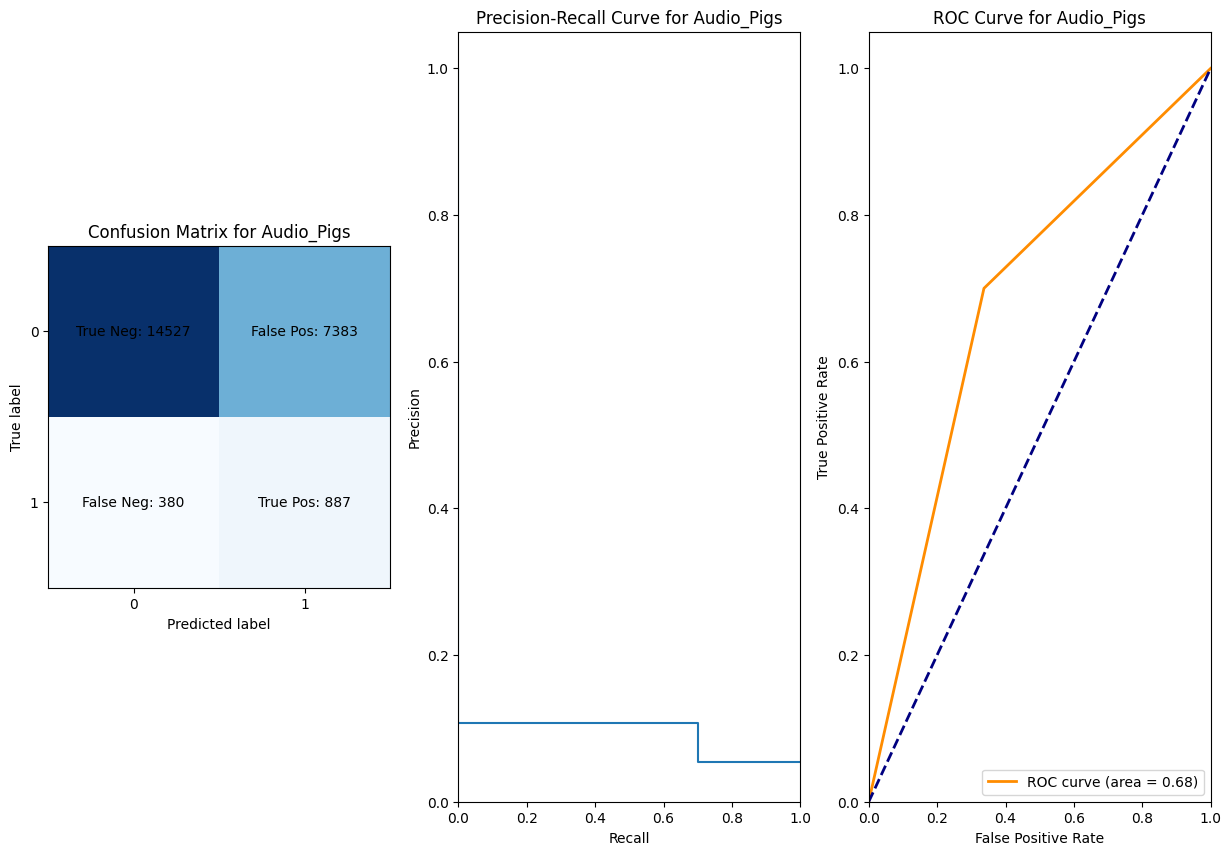

In [ ]:
# evaluation metrics for pigs
# ridge classifier balanced, svd


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"], y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"],
    y_pred_pigs,
    "Precision-Recall Curve for Audio_Pigs",
    ax=axs[1],
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

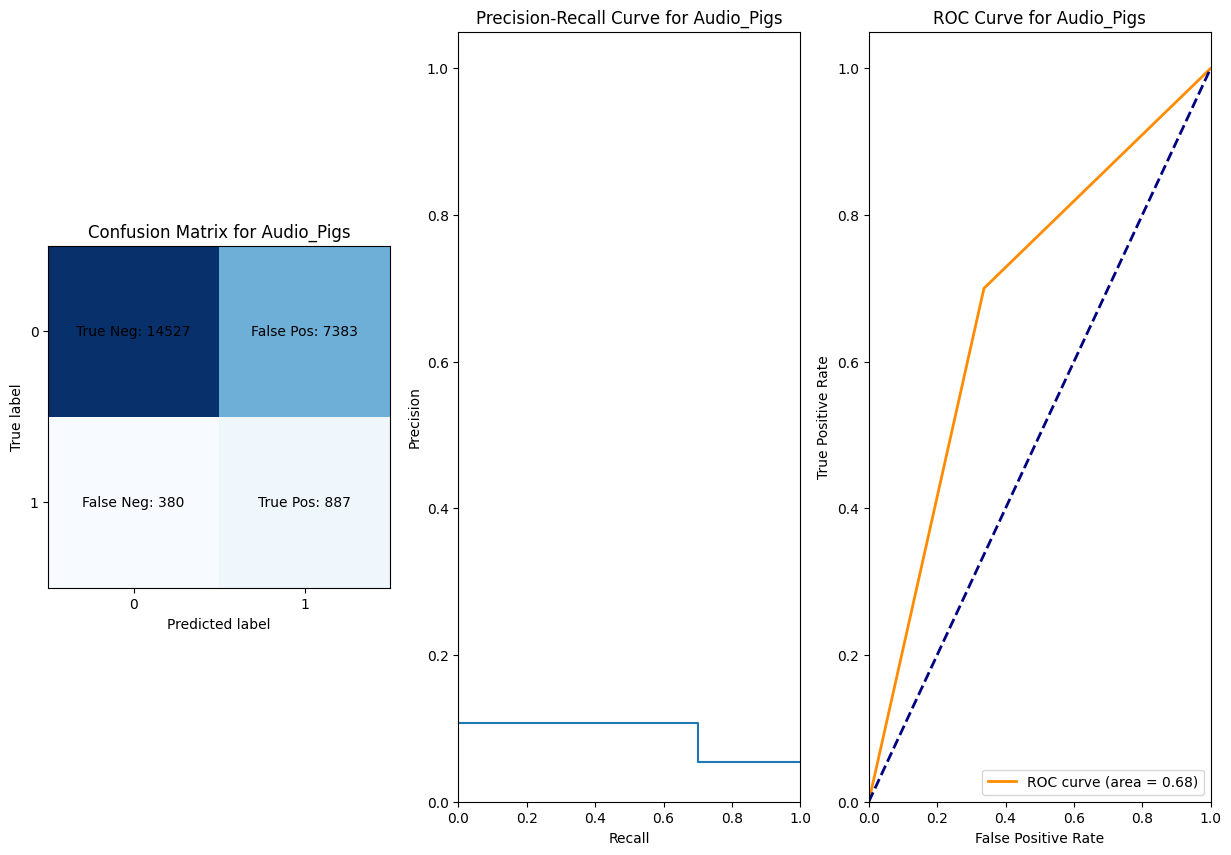
Accuracy: 0.6650558743581999
Precision: 0.10725513905683193
Recall: 0.7000789265982637
F1 Score: 0.18601237286358394
Confusion Matrix:
[[14527  7383]
 [  380   887]]


Cook:


In [ ]:
# cook all ft
rc_cook = RidgeClassifier(class_weight="balanced", solver="svd")
rc_cook.fit(X_train, y_train["Audio_Cook"])
y_pred_cook = rc_cook.predict(X_test)

Metrics for Audio_Cook : 
Accuracy: 0.7717996289424861
Precision: 0.04522153057488099
Recall: 0.7694704049844237
F1 Score: 0.085422790938959
Confusion Matrix:
[[17641  5215]
 [   74   247]]


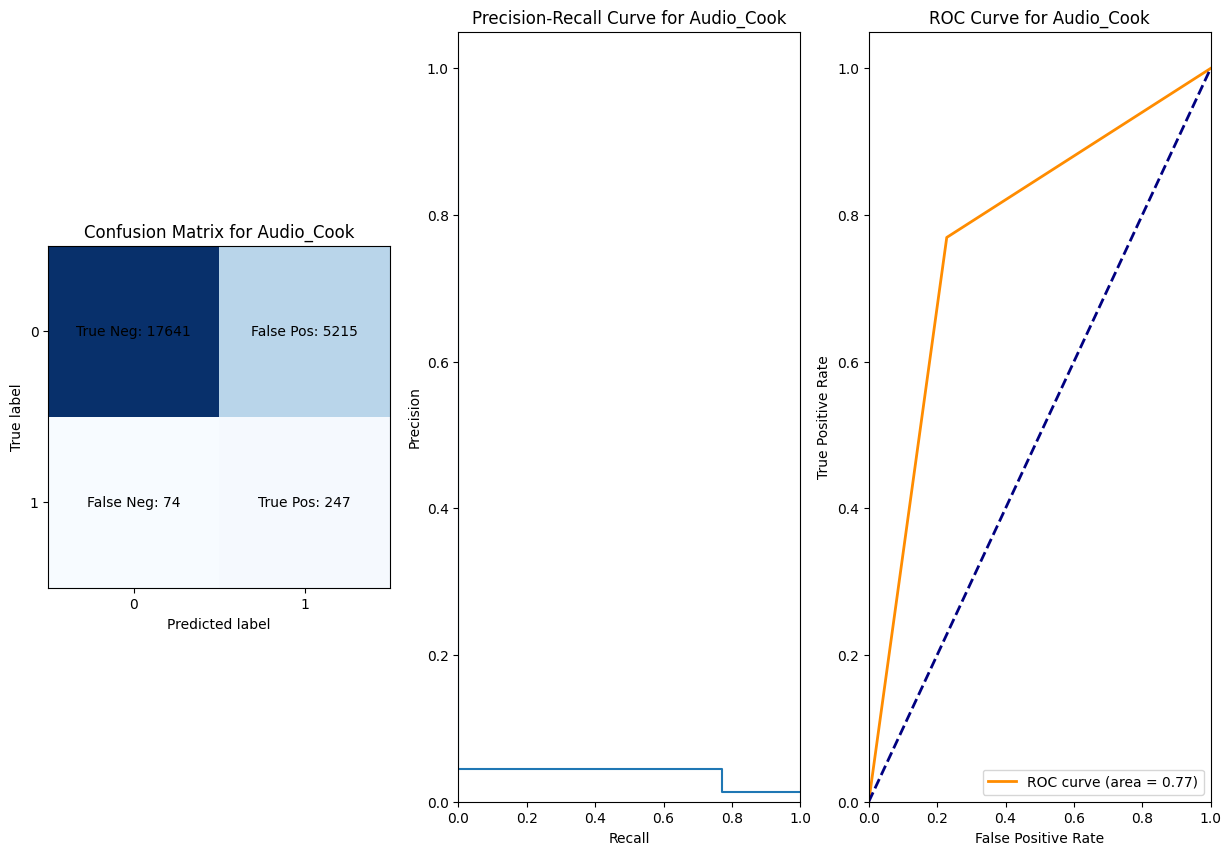

In [ ]:
# all ft
accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"], y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook : ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"],
    y_pred_cook,
    "Precision-Recall Curve for Audio_Cook",
    ax=axs[1],
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

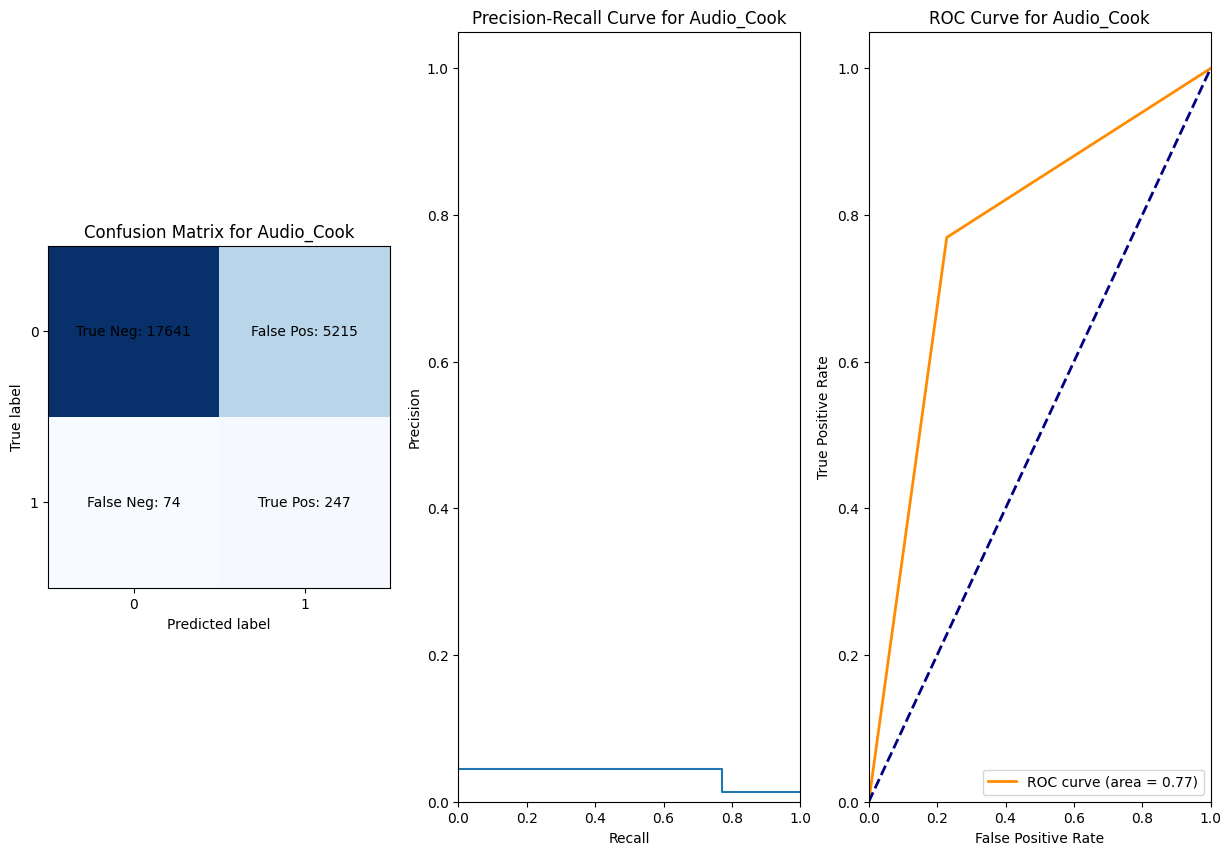
Metrics for Audio_Cook :
Accuracy: 0.7717996289424861
Precision: 0.04522153057488099
Recall: 0.7694704049844237
F1 Score: 0.085422790938959
Confusion Matrix:
[[17641  5215]
 [   74   247]]


Miss Piggy:


In [ ]:
#all ft
rc_mp = RidgeClassifier(class_weight='balanced',solver='svd')
rc_mp.fit(X_train,y_train["Audio_MissPiggy"])
y_pred_mp = rc_mp.predict(X_test)#all ft
accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Audio_Pigs", ax=axs[2])accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy : ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Miss Piggy", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for Miss Piggy", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Miss Piggy", ax=axs[2])

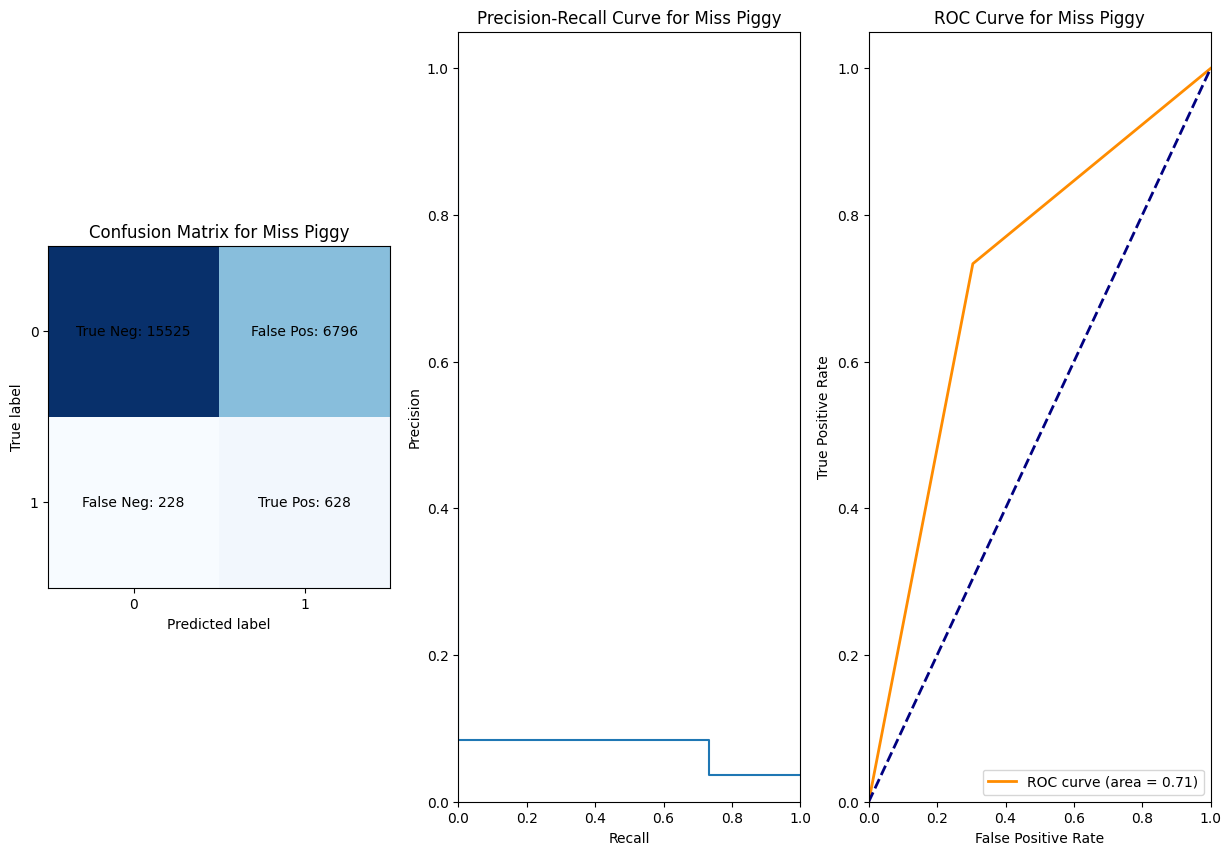
Metrics for Audio_MissPiggy :
Accuracy: 0.6969409328213315
Precision: 0.08459051724137931
Recall: 0.7336448598130841
F1 Score: 0.15169082125603864
Confusion Matrix:
[[15525  6796]
 [  228   628]]


Combined metrics:


In [ ]:
# combined metrics
y_test["combined"] = (
    y_test["Audio_Pigs"] + y_test["Audio_Cook"] * 2 + y_test["Audio_MissPiggy"] * 4
)
combined_pred = y_pred_pigs + y_pred_cook * 2 + y_pred_mp * 4

In [ ]:
# combined evaluation metrics
# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test["combined"], combined_pred)
precision_general = precision_score(
    y_test["combined"], combined_pred, average="weighted"
)
recall_general = recall_score(y_test["combined"], combined_pred, average="weighted")
f1_general = f1_score(y_test["combined"], combined_pred, average="weighted")
conf_matrix_general = confusion_matrix(y_test["combined"], combined_pred)

print(f"Accuracy: {accuracy_general}")
print(f"Precision: {precision_general}")
print(f"Recall: {recall_general}")
print(f"F1 Score: {f1_general}")
print(f"Confusion Matrix:\n{conf_matrix_general}")

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plot_global_confusion_matrix_sm2(
    y_test["combined"], combined_pred, "Pigs", "Swedish Chef", "Miss Piggy"
)

**Global confusion matrix & metrics:**
Accuracy: 0.4449238469172024  
Precision: 0.9120687924360174  
Recall: 0.4449238469172024  
F1 Score: 0.5766860010524871  
Confusion Matrix:

```
[[9594 1196 3298  617  969 4851  132  932]
 [  84   65   60   73    4   99    3   23]
 [  32   13  177   50    4   18    2   25]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [ 140   38   37   21   51  476    6   87]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]
```


## Result Discussion, observations and other things we tried to improve performance

Similar to Similarity Modelling 1, the performance of the model has been evaluated under four angles:  
Remark: Miss Piggy has been treated seperately as in doubt of her Auio_MissPiggy being a subset of Audio_Pigs.

- Pigs_Audio classification (metrics/plots for success at classifying frames where Pigs_Audio flag is true)
- Swedish Chef classification (metrics / plots for sucess at classifying frames where Audio_Cook flag is true)
- Miss_Piggy_Audio classification (metrics for success at classifying frames where MissPiggy_Audio flag is true)
- Overall classification performance (metrics/plots for the general multi-class classification task - weighted performance metrics have been employed).

The best performing model uses the following features: - 19 MFCCs - 2 Poly Features - 5 Spectral_contrast - 6 Chroma - Sharpness - Spectral rolloff

All these values are fed, as a vector of values, into a ridge classifier with single value decomposition solver and balanced weight. All parameters are normalized, to make sure they are all of equal importance in the distance metric that the classifier uses by constraining them to the same order of magnitude.
This way, the best performing model, with the features described above, achieves the following performance metrics (in the random split, as we from Similarity Modelling 1 know that a random split leads to better performance):

**Performance with the random split:**

<table>
<thead>
 <tr>
 <th><b>Experiment</b></th>
 <th><b>F1 </b></th>
 <th><b>Accuracy</b></th>
 <th><b>Precision</b></th>
 <th><b>Recall</b></th>
 </tr>
</thead>
<tbody>
 <tr>
 <td><b>Pigs detection</b></td>
 <td>0.17907</td>
 <td>0.6511</td>
 <td>0.1027</td>
 <td>0.6961</td>
 </tr>
 <tr>
 <td><b>Swedish Chef detection</b></td>
 <td>0.0866</td>
 <td>0.7689</td>
 <td>0.0458</td>
 <td>0.7912</td>

<tr>
 <td><b>Miss Piggy detection</b></td>
 <td>0.1452</td>
 <td>0.6851</td>
 <td>0.0807</td>
 <td>0.7243</td>

 </tr>
 <tr>
 <td><b>Overall multi-class classification</b></td>
 <td>0.5766</td>
 <td>0.4449</td>
 <td>0.9120</td>
 <td>0.4449</td>
 </tr>
</tbody>
</table>
<img src="../results/sim2_audio/sm2_pigs_best.png" style="max-width:75%; display: block; margin: 0 auto">

The general performance we have achieved is not as good as we would wish, but it still can bring valuable information to the hybrid classifier that also uses visual information - detecting solely on audio is not as easy.  
We observed that there are no signficant performance differences for the three models and all characters seem to have a similar presence rate. As they are all not present very often, the recall is signficantly higher than the precision and the accuracy does not look too bad either. This performance is reflected in the ROC and precision-recall curves. The ROC curve does not look too bad and indicates that the models are better than random guessing (that would be 0.5, but we do be having: pigs: 0.67, cook: 0.78 and miss piggy: 0.7) The preciscion-recall curves, however, look pretty poor for all three models (close to zero). The confusion matrices show that all three models do be having a tendency towards false positives rather than false negatives. This may be due to class imbalances (more true negatives than true positives). Data quality and feature representation contribute to the poor performance as well. With our given resources (Laptops) it was not easy to extract such large amounts of features in short time. Further, we unfortunately were unable to process several enriching audio features to our needs (dataframe level with sampling rate 25 frames/s, issues describe in nb previously). Despite trying to use differt features and feature combinations, we also tried different classifier parameters and even classifiers to achieve better performance - unfortunately in vain.  
The overall performance seems a little better, except for accuracy, all other measures indicate better performance. This may be due the majority of frames featuring neither of the characters.

Even though the above performance is the best we achieved, multiple approaches have been tried to improve the performance of the model.

- We tried using poly_features & mel_centroid only as these features have not been used in SM1. This did not work at all, we could not predict a single character presence. All measures, despite accuracy (quite ok as the characters are not present in most frames), were 0.
  - tried with ridge classifier, auto solver, no weight adjustment
  - tried with svm, rbf kernel, to see whether it was a classifier issue - it was not
  - same terrible result
  - for pigs for example, the performance was terrible
    Accuracy: 0.9453337360314105
    Precision: 0.0
    Recall: 0.0
    F1 Score: 0.0
    Confusion Matrix:
    [[21910     0]
  [ 1267     0]]

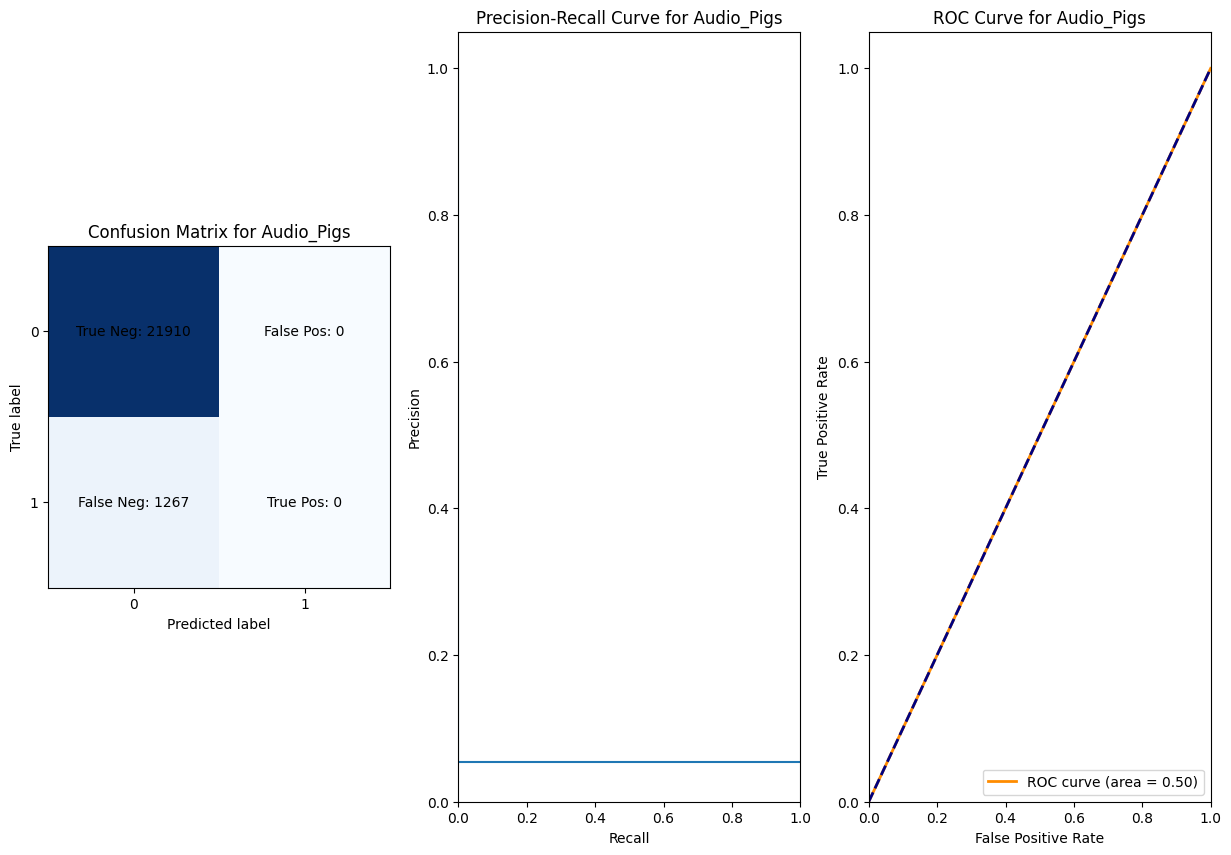

- We tried ridge classifier with poly features only, it performed very bad.
  - for pigs: e.g.: a little better than random guessing
    Accuracy: 0.4952323424084221
    Precision: 0.06409827845562427
    Recall: 0.6053670086819258
    F1 Score: 0.11592231542356231
    Confusion Matrix:
    [[10711 11199]
        [  500   767]]

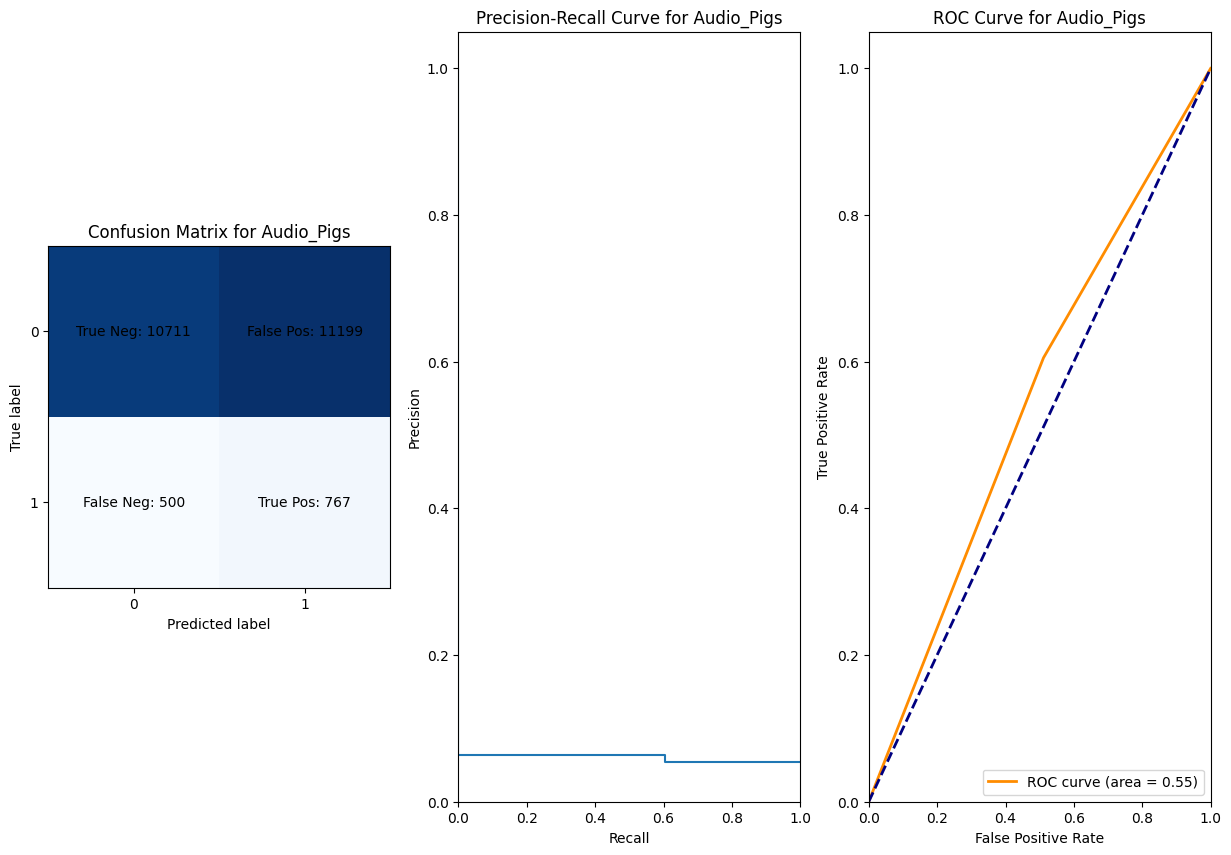

- for cook: e.g.: very close to random guessing
  Accuracy: 0.5637053975924408
  Precision: 0.014768559817623154
  Recall: 0.46417445482866043
  F1 Score: 0.028626320845341016
  Confusion Matrix:
  [[12916  9940]
                        [  172   149]]
  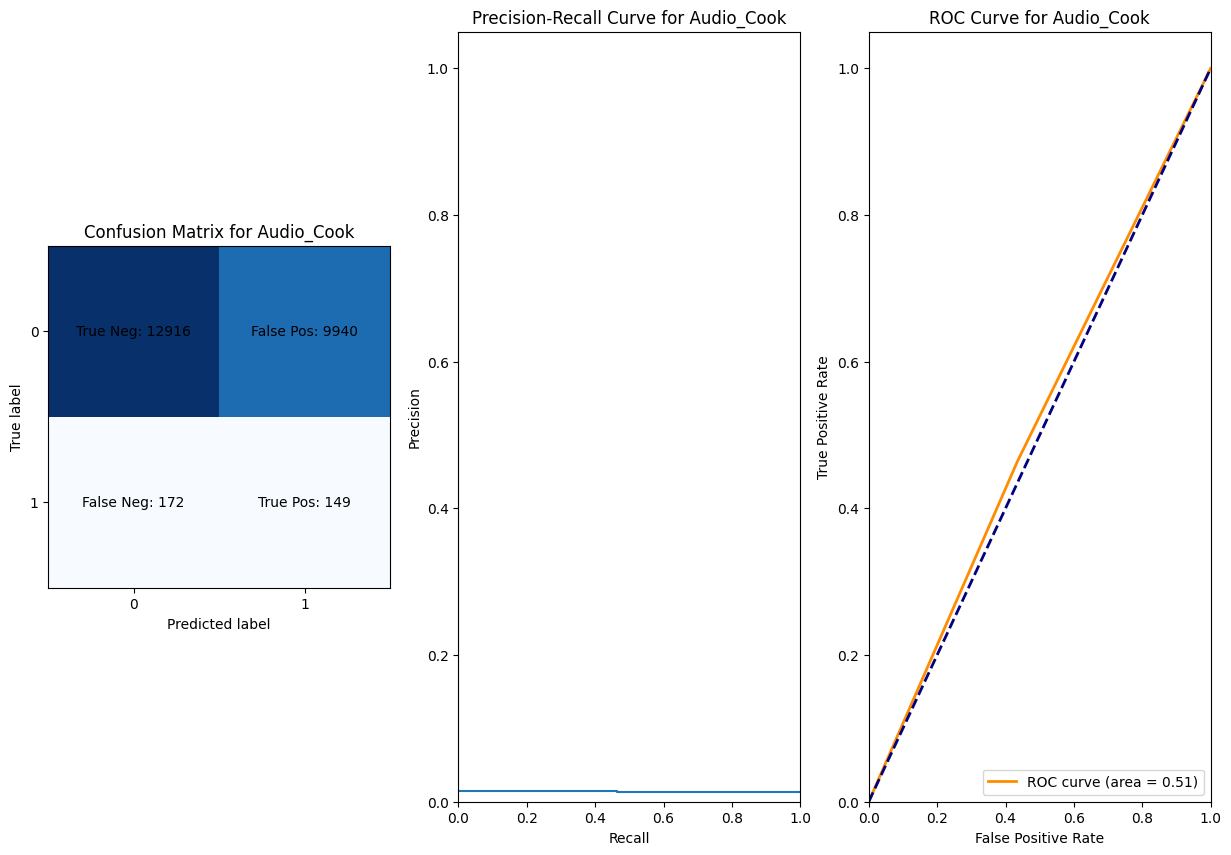

  - for miss piggy:e.g.: a little better than random guessing
    Accuracy: 0.5052422660396082
    Precision: 0.046344591705857204
    Recall: 0.633177570093458
    F1 Score: 0.08636762010995139
    Confusion Matrix:
    [[11168 11153]
            [  314   542]]

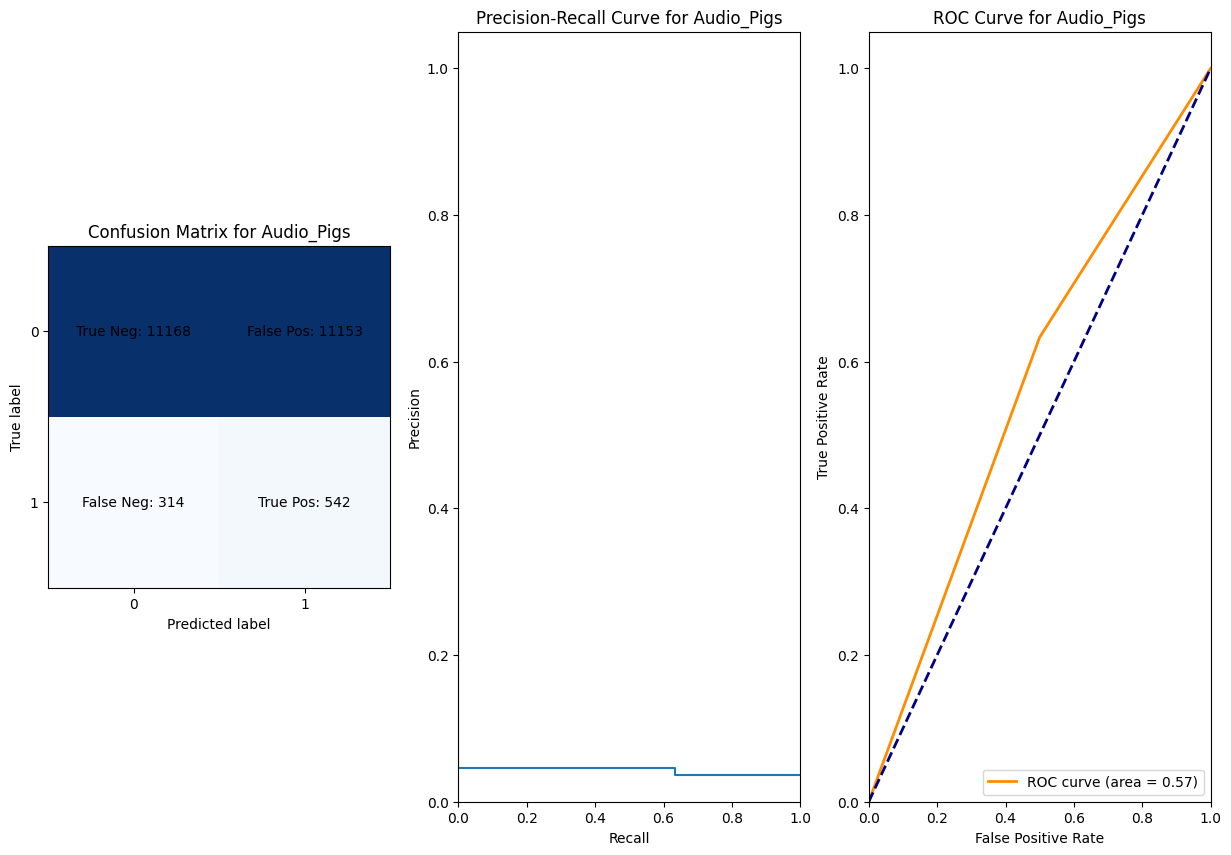

- We tried ridge classifier with all features from SM1 - very similar performance, almost the same for pigs, a little better for miss piggy, a little bit worse for the swedish chef
  pigs:
  Accuracy: 0.6688095957198947
  Precision: 0.10782034022763431
  Recall: 0.6953433307024467
  F1 Score: 0.18669209578300489
  Confusion Matrix:
  [[14620  7290]
              [  386   881]]

                  cook:
                  Accuracy: 0.7755964965267291
                  Precision: 0.04663693794128577
                  Recall: 0.7819314641744548
                  F1 Score: 0.08802384709801858
                  Confusion Matrix:
                  [[17725  5131]
                  [   70   251]]

                  miss piggy:
                  Accuracy: 0.7050955688829443
                  Precision: 0.08748447633503519
                  Recall: 0.7406542056074766
                  F1 Score: 0.15648525237566333
                  Confusion Matrix:
                  [[15708  6613]
                  [  222   634]]


      - We also tried different solvers for the ridge classifier
          e.g.: for pigs solvers: cholesky, sparse_cg, sag, saga returned the same metrics of:
          Accuracy: 0.6688095957198947
          Precision: 0.10782034022763431
          Recall: 0.6953433307024467
          F1 Score: 0.18669209578300489
          Confusion Matrix:
          [[14620  7290]
          [  386   881]]

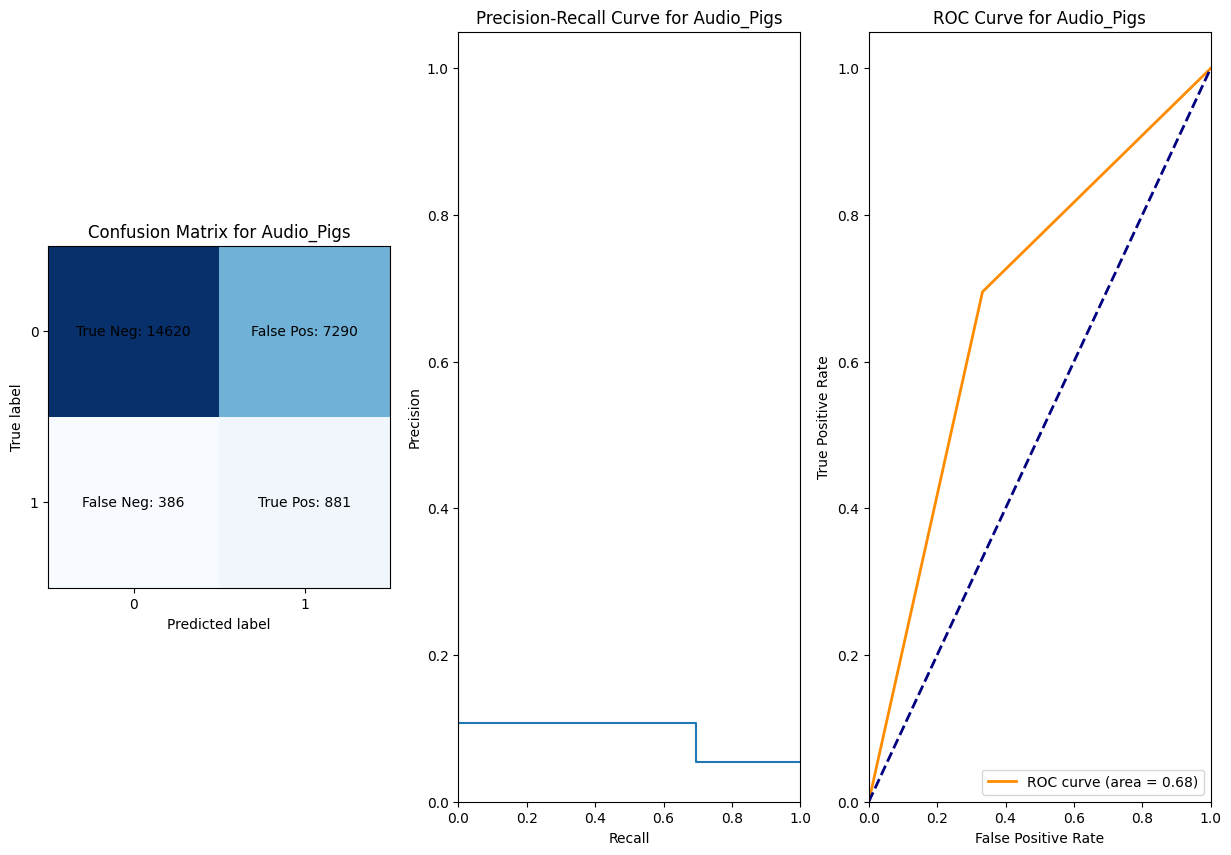
lsqr - minimally worse:
Metrics for Audio_Pigs ridge classifier, balanced, lsqr:
Accuracy: 0.6686370108297018
Precision: 0.10767160161507403
Recall: 0.6945540647198106
F1 Score: 0.18644067796610167
Confusion Matrix:
[[14617  7293]
                [  387   880]]
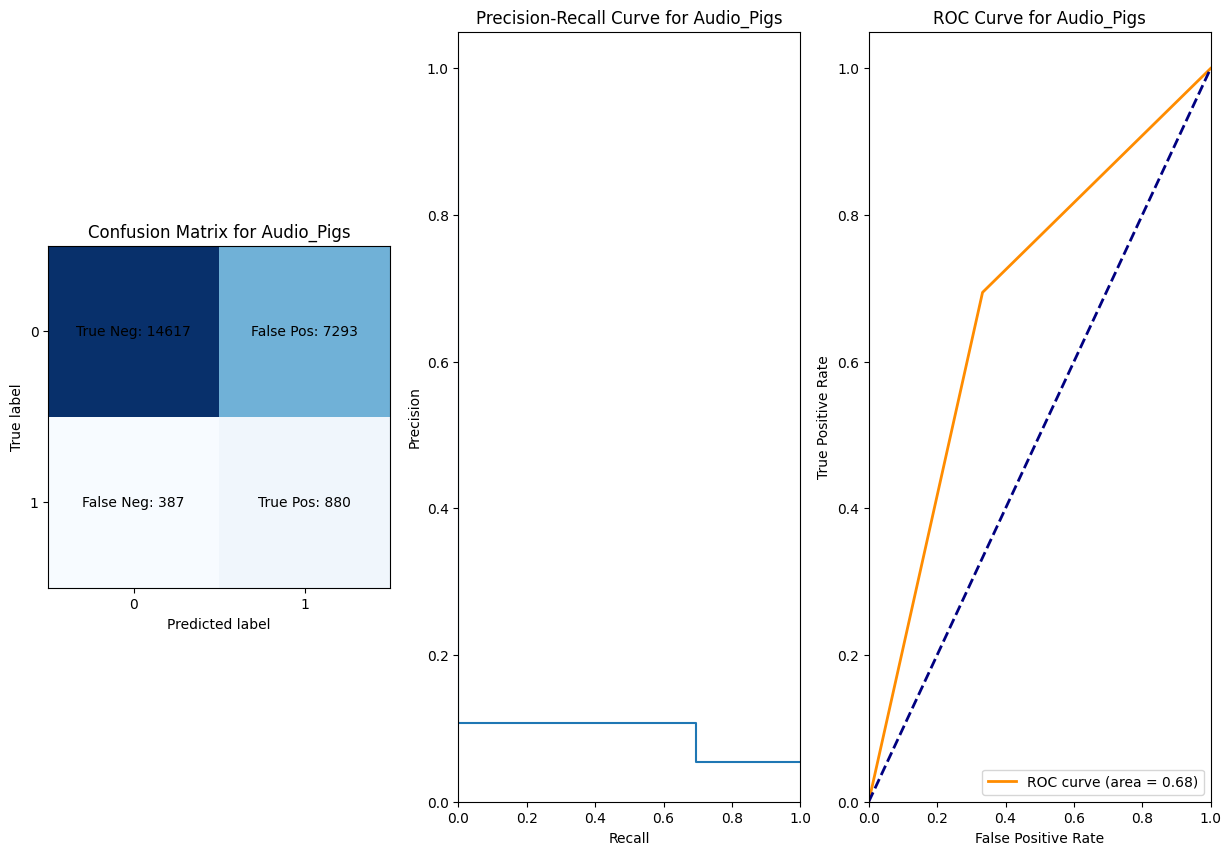
lbfgs - siginificantly worse:
Accuracy: 0.60072485653881
Precision: 0.0794102159031069
Recall: 0.5951065509076559
F1 Score: 0.14012265378182492
Confusion Matrix:
[[13169  8741]
                [  513   754]]
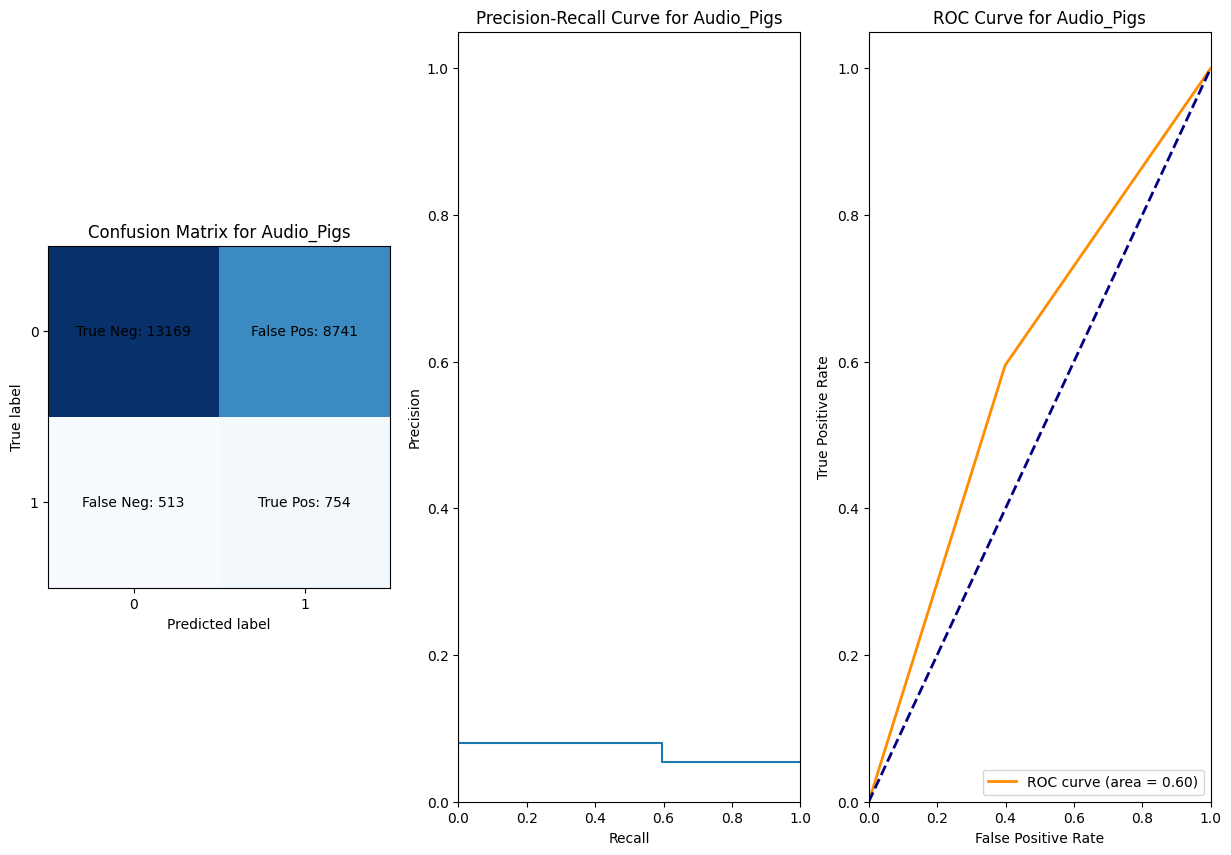

- We also tried with svm classifer with sigmoid kernel in an effort to improve bad performance: worked significantly worse, especially for swedish chef - only one true positive! and miss piggy only 3 true positives.

  - pigs:
    Accuracy: 0.9004185183587177
    Precision: 0.06516290726817042
    Recall: 0.06156274664561957
    F1 Score: 0.06331168831168832
    Confusion Matrix:
    [[20791  1119]
            [ 1189    78]]
    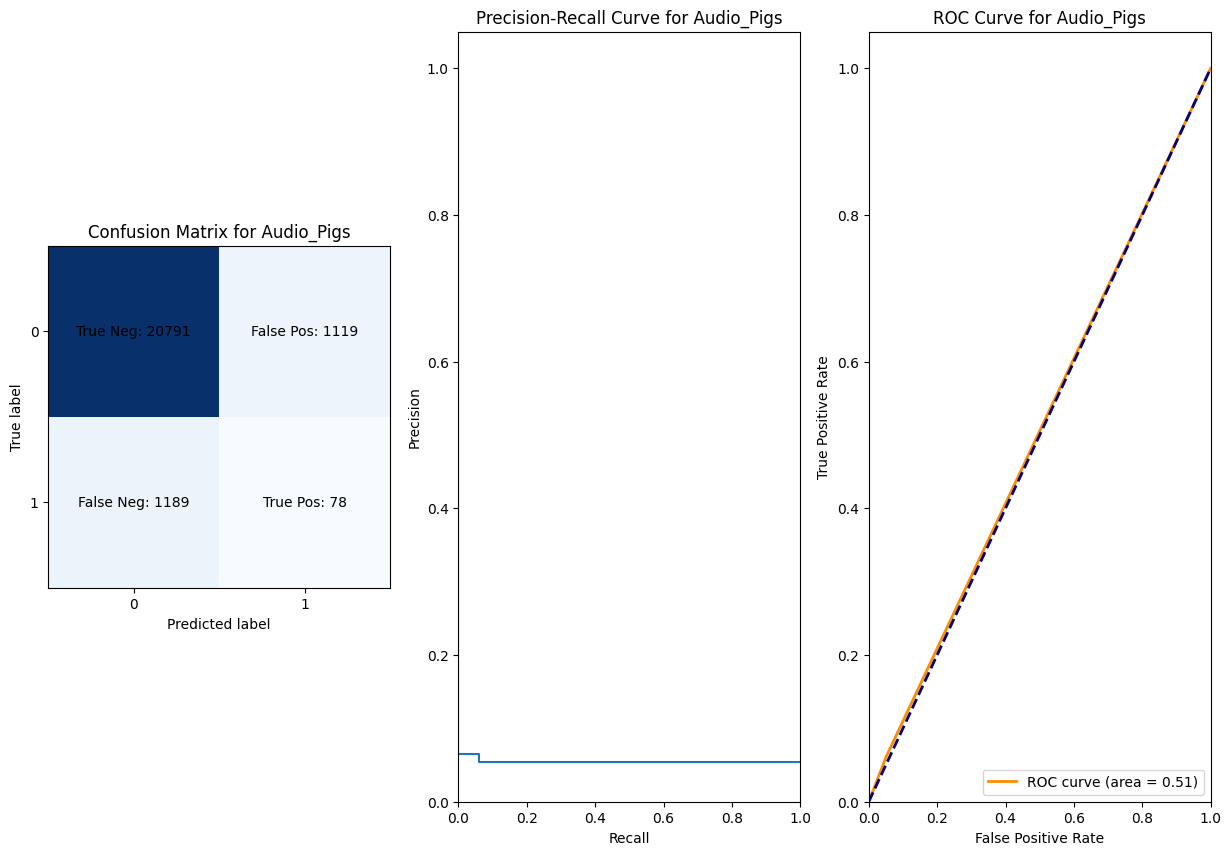 - cook:
    Accuracy: 0.9799801527376278
    Precision: 0.006896551724137931
    Recall: 0.003115264797507788
    F1 Score: 0.004291845493562232
    Confusion Matrix:
    [[22712   144]
  [  320     1]]
    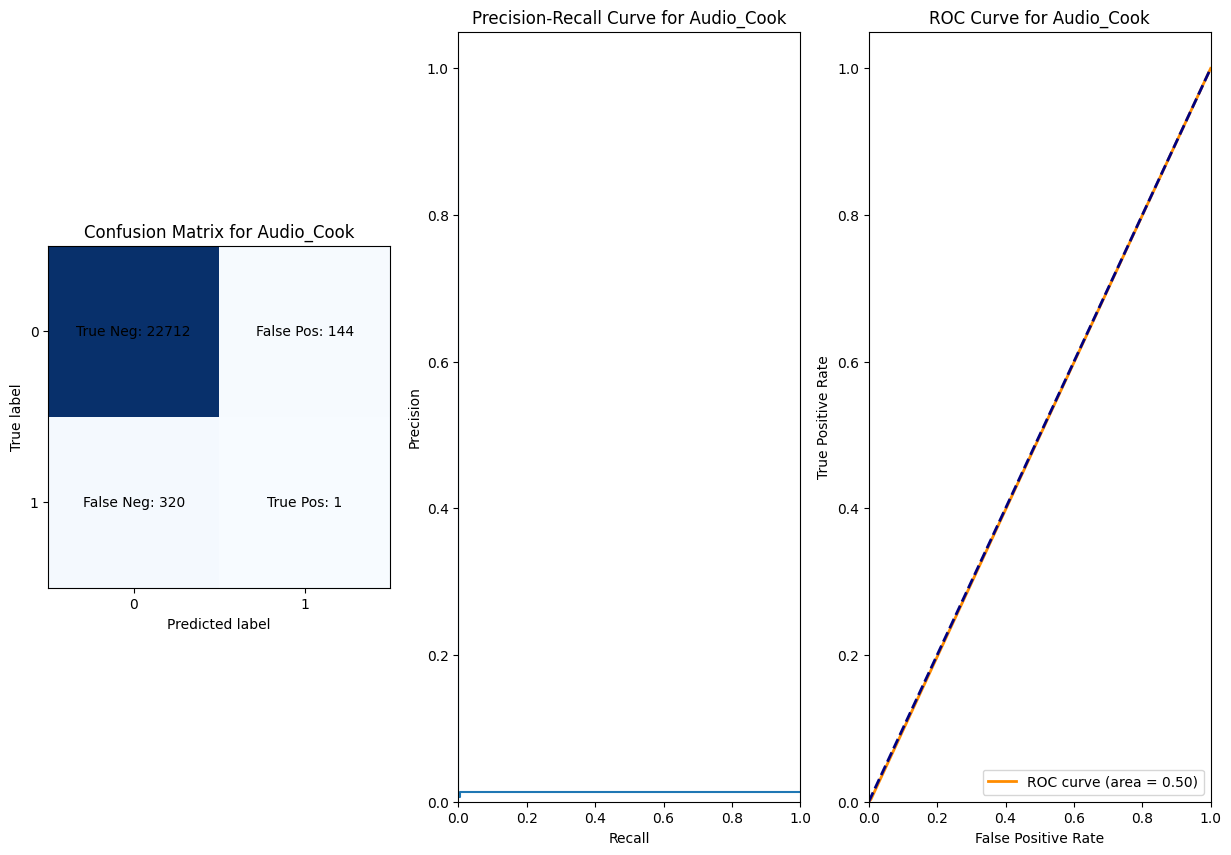
    miss piggy:
    Accuracy: 0.9570695085645252
    Precision: 0.020689655172413793
    Recall: 0.0035046728971962616
    F1 Score: 0.005994005994005994
    Confusion Matrix:
    [[22179   142]
  [  853     3]]
    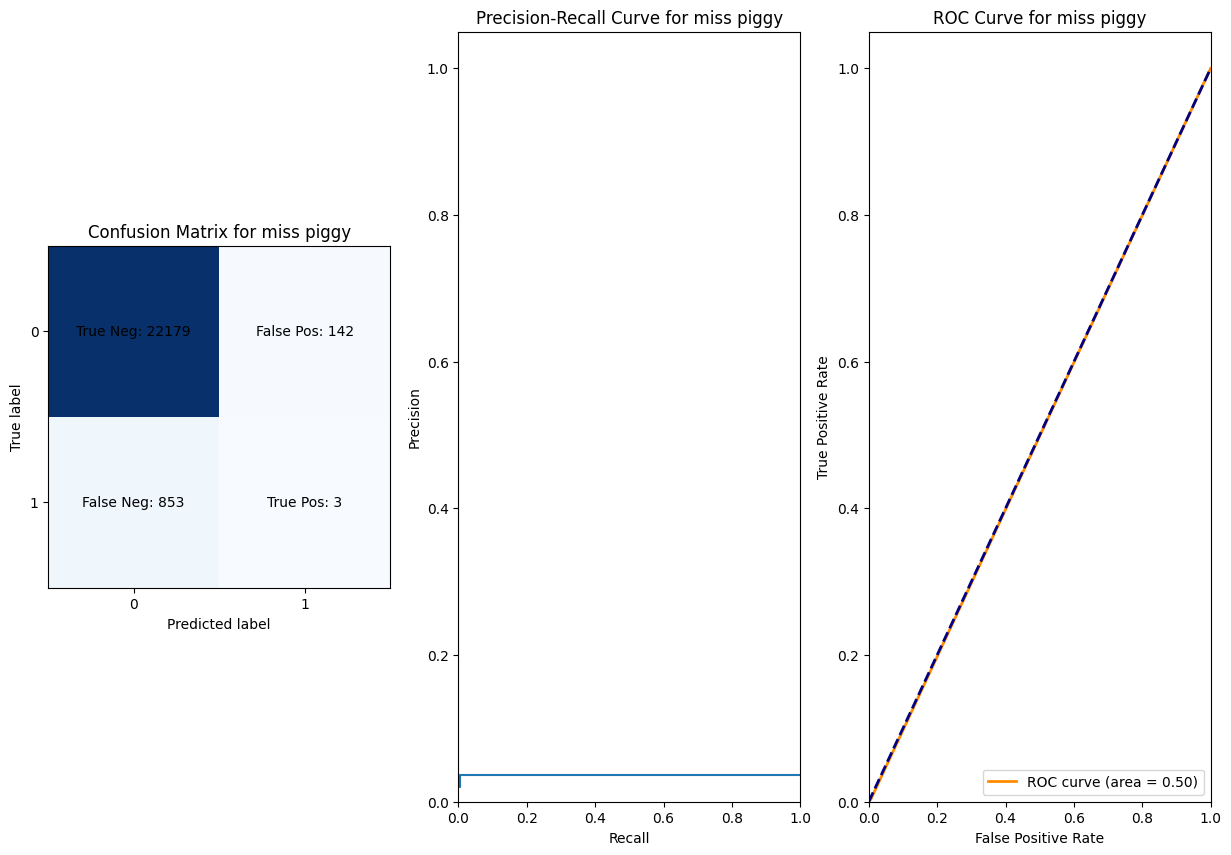

- mfcc & contrast: nearly the same as best
  e.g.: pigs
  Accuracy: 0.651076498252578
  Precision: 0.1027493010251631
  Recall: 0.6961325966850829
  F1 Score: 0.17906811491219166
  Confusion Matrix:
  [[14208  7702]
      [  385   882]]
  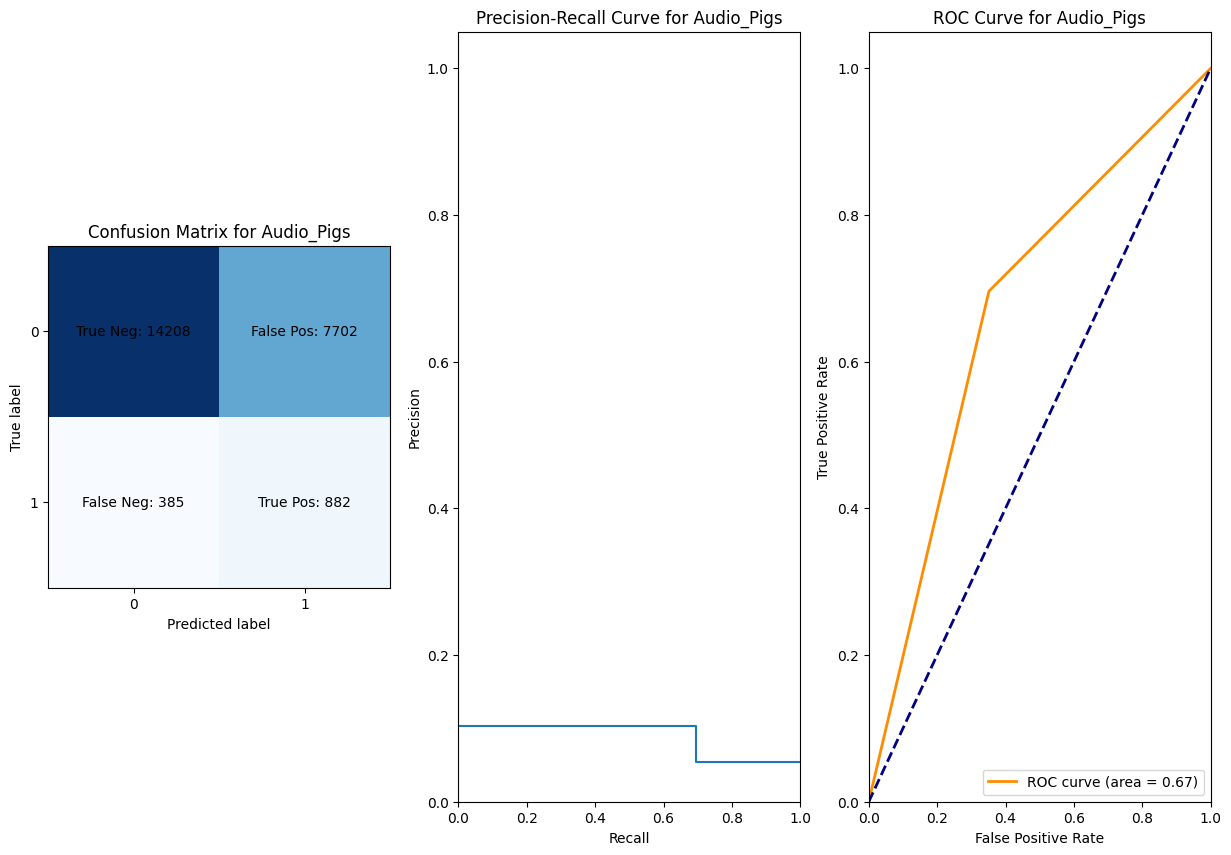

- mfcc & chroma: little bit worse
  e.g. pigs:
  Accuracy: 0.6600077663200586
  Precision: 0.10472205618649133
  Recall: 0.691397000789266
  F1 Score: 0.18189368770764117
  Confusion Matrix:
  [[14421  7489]
      [  391   876]]
- poly feautures & sharpness: pretty bad
  e.g.: pigs
  Accuracy: 0.4950597575182293
  Precision: 0.06407685881370091
  Recall: 0.6053670086819258
  F1 Score: 0.11588728563873989
  Confusion Matrix:
  [[10707 11203]
        [  500   767]]
  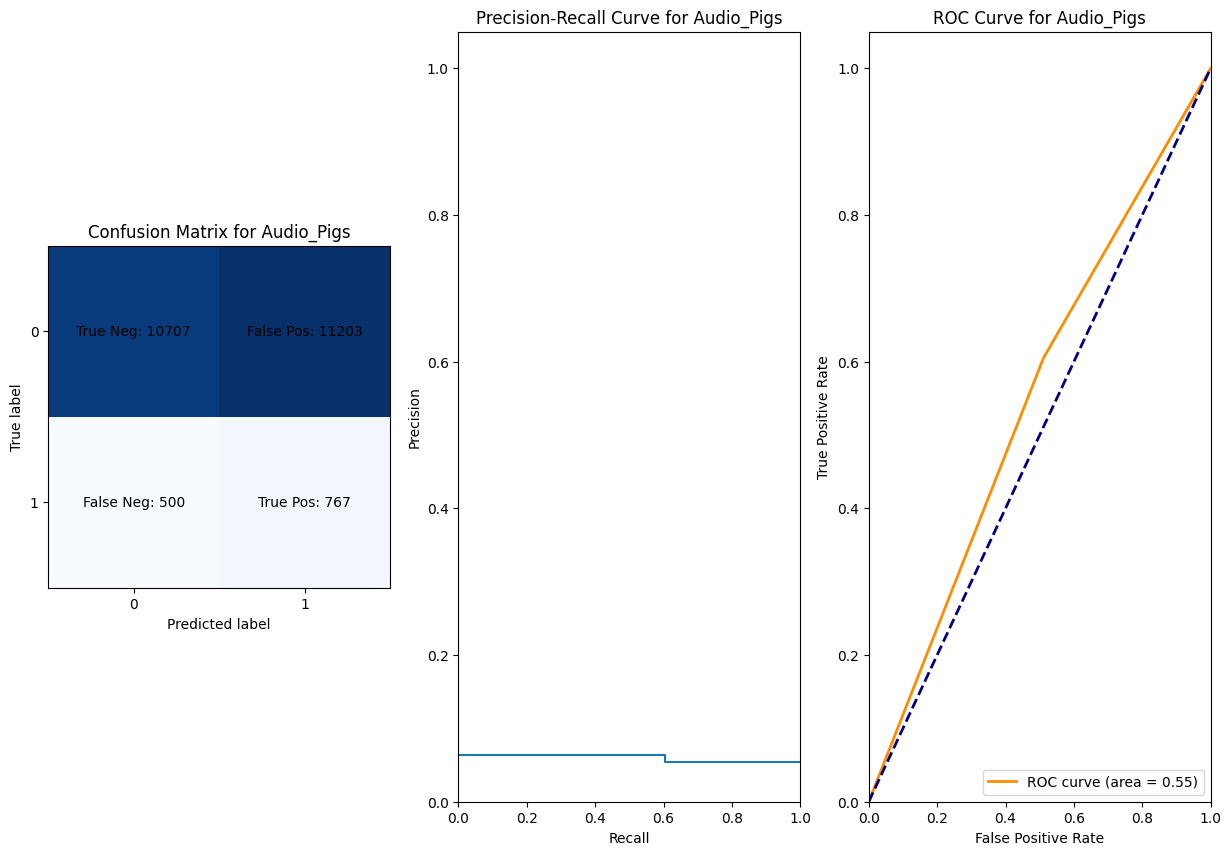

- mfcc & chroma & sharpness: pretty bad
  e.g.: pigs
  Accuracy: 0.4950597575182293
  Precision: 0.06407685881370091
  Recall: 0.6053670086819258
  F1 Score: 0.11588728563873989
  Confusion Matrix:
  [[10707 11203]
    [  500   767]]
  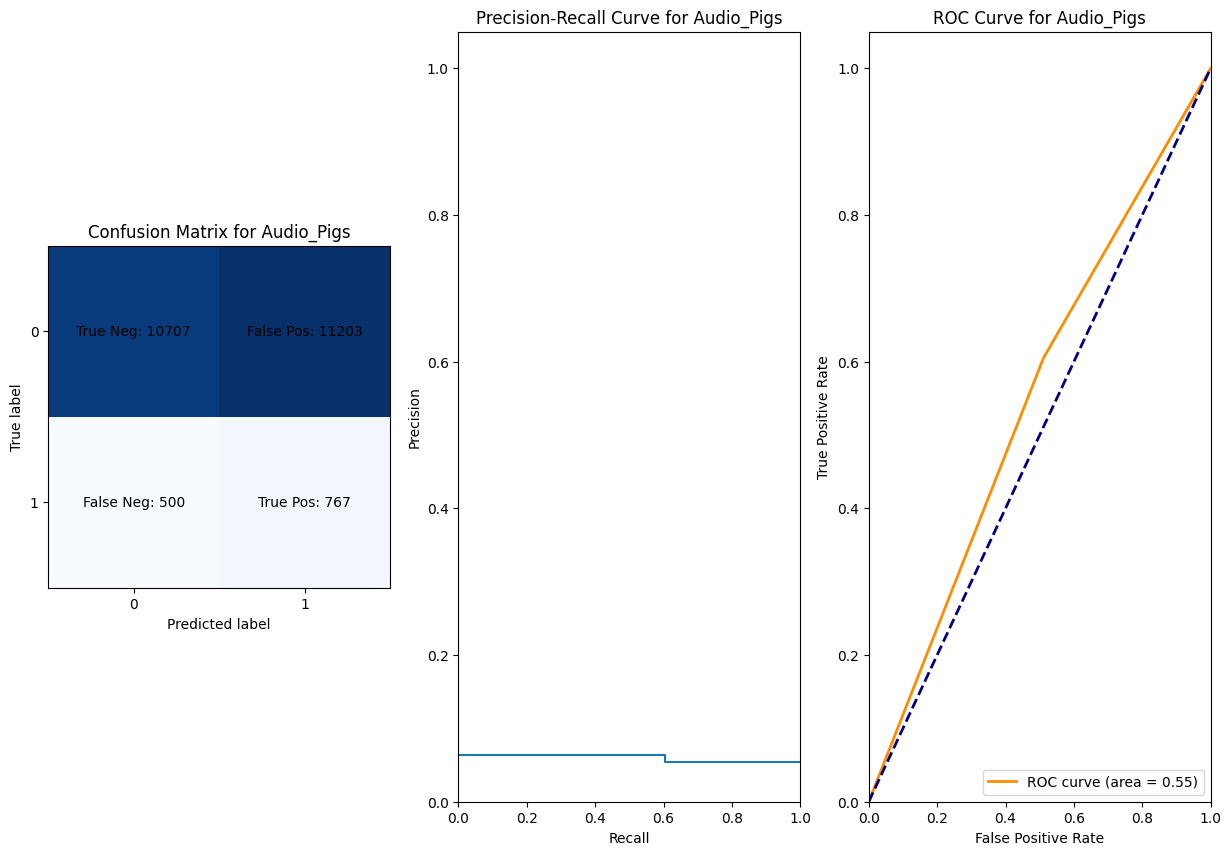

- mfcc & poly features
  e.g.: for pigs very similar to all features
  Accuracy: 0.6501704275790654
  Precision: 0.10305210630149704
  Recall: 0.7008681925808997
  F1 Score: 0.17968433832456493
  Confusion Matrix:
  [[14181  7729]
      [  379   888]]
  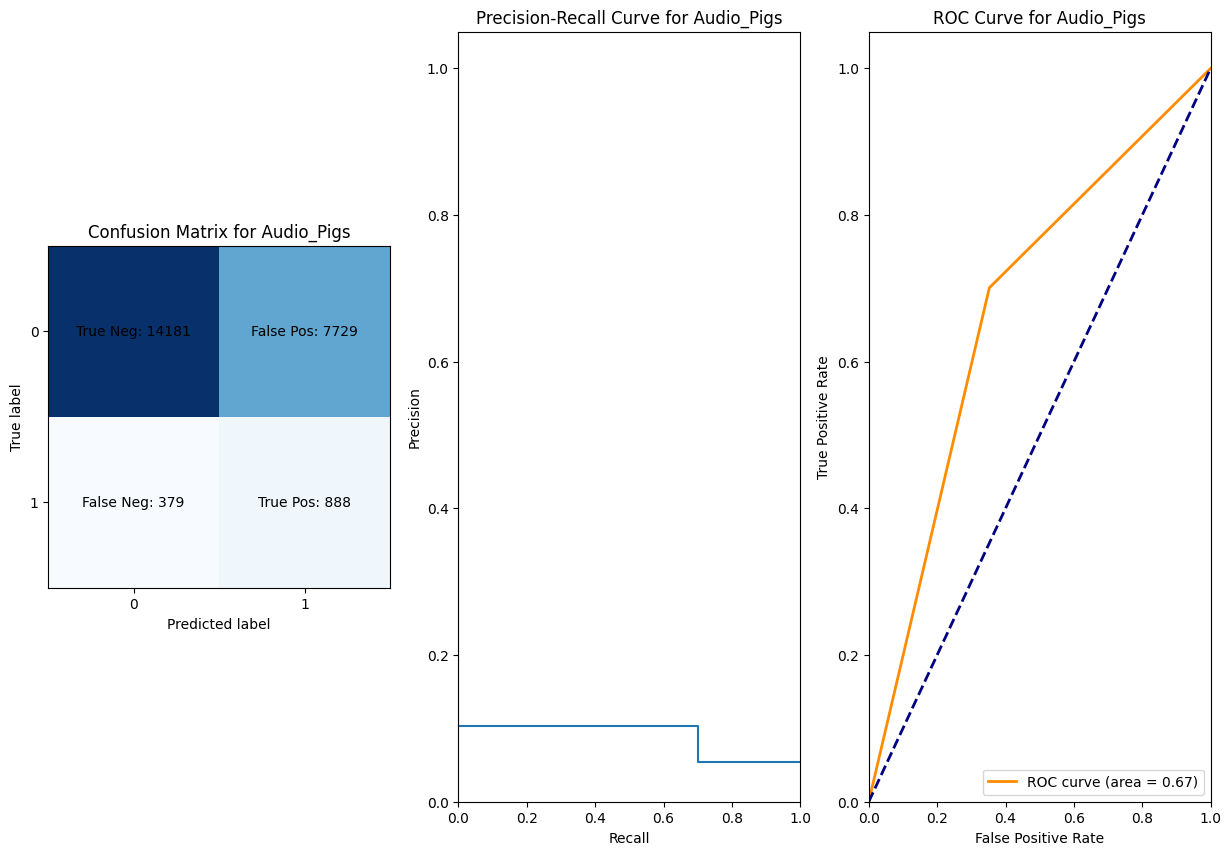
  e.g: for cook very similar all features
  Accuracy: 0.7631272382102947
  Precision: 0.04490227152667723
  Recall: 0.794392523364486
  F1 Score: 0.08499999999999999
  Confusion Matrix:
  [[17432  5424]
      [   66   255]]
  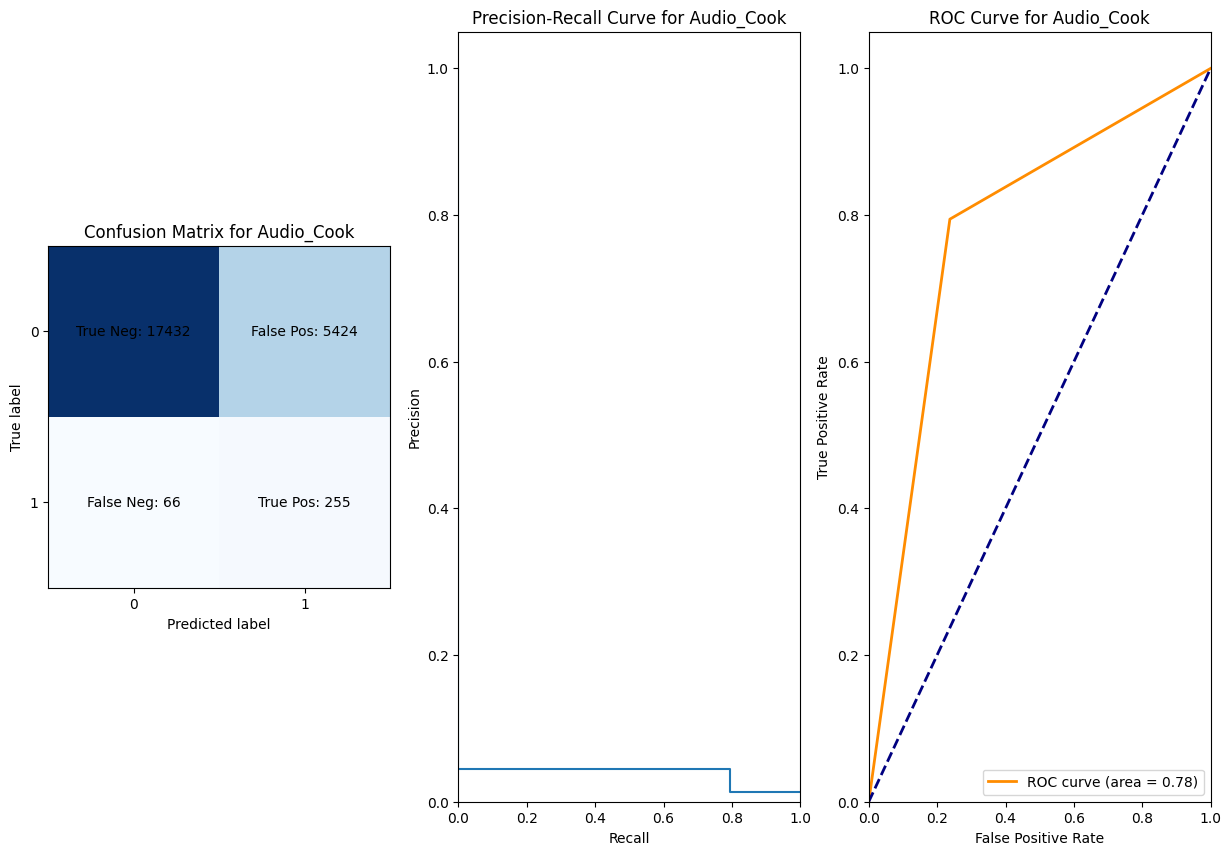
  e.g: for miss piggy very similar to all features
  Accuracy: 0.6673857703758036
  Precision: 0.07535010534143016
  Recall: 0.7102803738317757
  F1 Score: 0.13624649859943977
  Confusion Matrix:
  [[14860  7461]
      [  248   608]]
  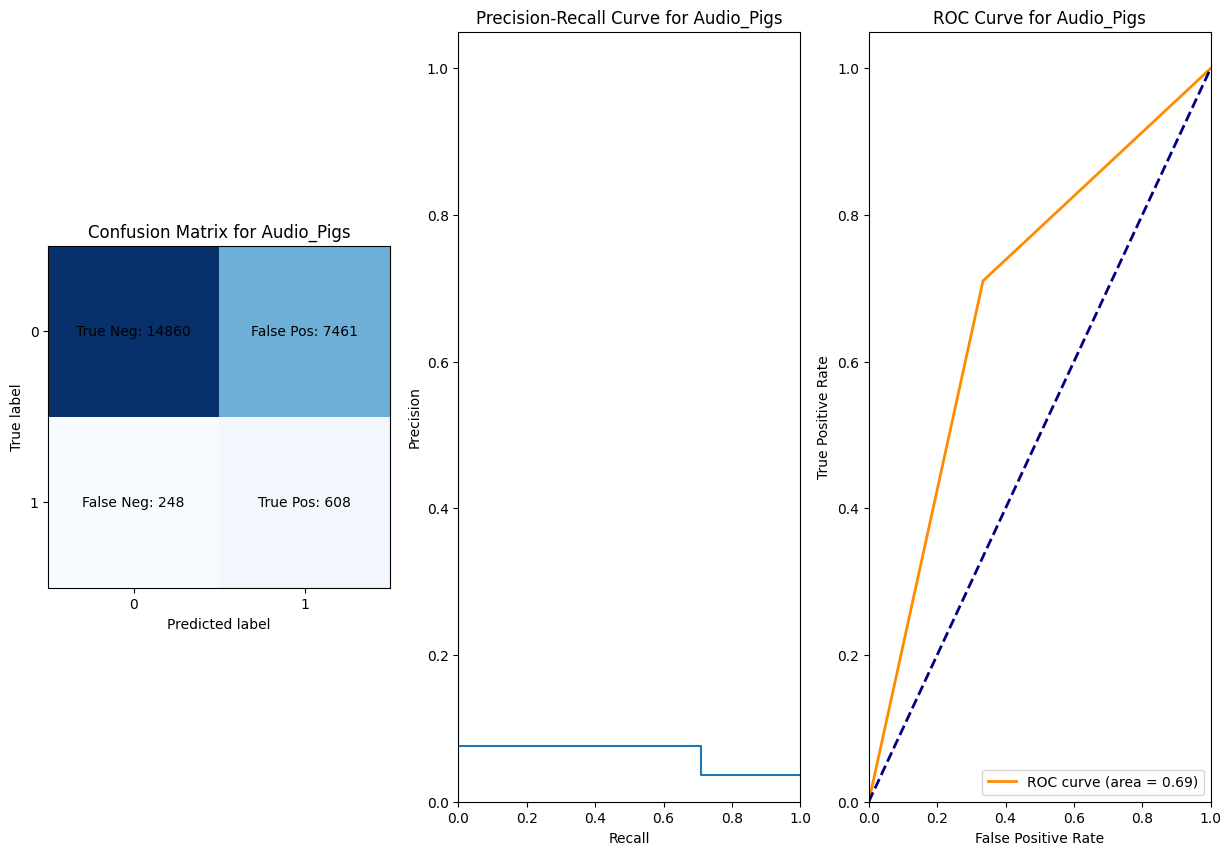
